In [99]:
import math
import collections
import urllib.request

import numpy as np
import pandas as pd

from matplotlib import offsetbox
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pdfkit as pdf

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from datetime import date
%matplotlib inline

In [100]:
pd.options.display.max_rows = 16

In [101]:
canada = pd.read_csv('canada.csv')

In [102]:
len(canada)

8922

In [103]:
canada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8922 entries, 0 to 8921
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pruid                8922 non-null   int64  
 1   prname               8922 non-null   object 
 2   prnameFR             8922 non-null   object 
 3   date                 8922 non-null   object 
 4   update               3926 non-null   float64
 5   numconf              8922 non-null   int64  
 6   numprob              6312 non-null   float64
 7   numdeaths            8803 non-null   float64
 8   numtotal             8922 non-null   int64  
 9   numtested            4905 non-null   float64
 10  numtests             8922 non-null   int64  
 11  numrecover           8398 non-null   float64
 12  percentrecover       8194 non-null   float64
 13  ratetested           4566 non-null   float64
 14  ratetests            8258 non-null   float64
 15  numtoday             8922 non-null   i

In [104]:
canada.head()

pruid            prname              prnameFR        date  update  numconf  \
0     35           Ontario               Ontario  2020-01-31     NaN        3   
1     59  British Columbia  Colombie-Britannique  2020-01-31     NaN        1   
2      1            Canada                Canada  2020-01-31     NaN        4   
3     35           Ontario               Ontario  2020-02-08     NaN        3   
4     59  British Columbia  Colombie-Britannique  2020-02-08     NaN        4   

   numprob  numdeaths  numtotal  numtested  ...  ratedeaths_last14  \
0      0.0        0.0         3        NaN  ...                NaN   
1      0.0        0.0         1        NaN  ...                NaN   
2      0.0        0.0         4        NaN  ...                NaN   
3      0.0        0.0         3        NaN  ...                NaN   
4      0.0        0.0         4        NaN  ...                NaN   

   numtotal_last7  ratetotal_last7  numdeaths_last7  ratedeaths_last7  \
0             NaN              NaN              NaN               NaN   
1             NaN              NaN              NaN               NaN   
2             NaN              NaN              NaN               NaN   
3             NaN              NaN              NaN               NaN   
4             NaN              NaN              NaN               NaN   

   avgtotal_last7  avgincidence_last7  avgdeaths_last7  avgratedeaths_last7  \
0             NaN                 NaN              NaN                  NaN   
1             NaN                 NaN              NaN                  NaN   
2             NaN                 NaN              NaN                  NaN   
3             NaN                 NaN              NaN                  NaN   
4             NaN                 NaN              NaN                  NaN   

   raterecovered  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  

[5 rows x 40 columns]

## Dropping all redundant columns

In [105]:
redundant_columns = ['pruid','prnameFR','update','numtotal','numprob','numconf','numdeaths','numtested','numtests','numrecover','percentrecover','ratetested','ratetests','percentoday','ratetotal','ratedeaths','percentdeath','numtestedtoday','percentactive','numactive','rateactive','numtotal_last14','ratetotal_last14','numdeaths_last14','ratedeaths_last14','numtotal_last7','ratetotal_last7','numdeaths_last7','ratedeaths_last7','avgtotal_last7','avgincidence_last7','avgdeaths_last7','avgratedeaths_last7','raterecovered']

In [106]:
canada.drop(redundant_columns, axis=1, inplace=True)

In [107]:
canada.head()

prname        date  numtoday  numdeathstoday  numteststoday  \
0           Ontario  2020-01-31         3             0.0            NaN   
1  British Columbia  2020-01-31         1             0.0            NaN   
2            Canada  2020-01-31         4             0.0            NaN   
3           Ontario  2020-02-08         0             0.0            NaN   
4  British Columbia  2020-02-08         3             0.0            NaN   

   numrecoveredtoday  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN

## Canada Lockdown Date

In [74]:
canadaLockdownDate = pd.read_csv('canada-updated-lockdwon-date.csv')

In [75]:
canadaLockdownDate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pruid   160 non-null    float64
 1   date    160 non-null    object 
 2   Class   160 non-null    float64
dtypes: float64(2), object(1)
memory usage: 34.3+ KB


In [51]:
canadaLockdownDate.head()

pruid        date  Class
0    1.0  2020-03-15    1.0
1    1.0  2020-05-01    0.0
2    1.0  2020-11-30    1.0
3    1.0  2020-12-18    0.0
4    1.0  2021-02-28    1.0

In [76]:
canadaLockdownDate['date'] = pd.to_datetime(canadaLockdownDate['date'])

In [77]:
canadaLockdownDate.head()

pruid       date  Class
0    1.0 2020-03-15    1.0
1    1.0 2020-05-01    0.0
2    1.0 2020-11-30    1.0
3    1.0 2020-12-18    0.0
4    1.0 2021-02-28    1.0

In [78]:
def expand_dates(ser):
    return pd.DataFrame({'date': pd.date_range(ser['date'].min(), date.today(), freq='D')})

newlockdownDF = canadaLockdownDate.groupby(['pruid']).apply(expand_dates).reset_index()\
          .merge(canadaLockdownDate, how='left')[['pruid', 'date', 'Class']].ffill()

In [79]:
newlockdownDF.head()

pruid       date  Class
0    1.0 2020-03-15    1.0
1    1.0 2020-03-16    1.0
2    1.0 2020-03-17    1.0
3    1.0 2020-03-18    1.0
4    1.0 2020-03-19    1.0

In [80]:
newlockdownDF.to_csv('newLockdown.csv',encoding='utf-8-sig')

In [57]:
newlockdownDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8380 entries, 0 to 8379
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   pruid   8380 non-null   float64       
 1   date    8380 non-null   datetime64[ns]
 2   Class   8380 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 261.9 KB


## Joining Canada Data and Canada Lockdown Date From Government

In [58]:
canada['date'] = pd.to_datetime(canada['date'])

In [59]:
bothDF = pd.merge(canada,newlockdownDF, how='left',left_on=['pruid','date'], right_on = ['pruid','date'])

In [60]:
bothDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8928 entries, 0 to 8927
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pruid              8928 non-null   int64         
 1   date               8928 non-null   datetime64[ns]
 2   numtoday           8928 non-null   int64         
 3   numdeathstoday     8809 non-null   float64       
 4   numteststoday      8856 non-null   float64       
 5   numrecoveredtoday  8404 non-null   float64       
 6   Class              7587 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 558.0 KB


In [61]:
bothDF.head(n=300)

pruid       date  numtoday  numdeathstoday  numteststoday  \
0       35 2020-01-31         3             0.0            NaN   
1       59 2020-01-31         1             0.0            NaN   
2        1 2020-01-31         4             0.0            NaN   
3       35 2020-02-08         0             0.0            NaN   
4       59 2020-02-08         3             0.0            NaN   
..     ...        ...       ...             ...            ...   
295     99 2020-03-26         0             0.0            0.0   
296      1 2020-03-26       634             4.0        10911.0   
297     59 2020-03-27         0             0.0         2754.0   
298     48 2020-03-27        56             0.0         1645.0   
299     47 2020-03-27         9             0.0          645.0   

     numrecoveredtoday  Class  
0                  NaN    NaN  
1                  NaN    NaN  
2                  NaN    NaN  
3                  NaN    NaN  
4                  NaN    NaN  
..                 ...    ...  
295                NaN    NaN  
296              230.0    1.0  
297                0.0    1.0  
298                0.0    1.0  
299                0.0    NaN  

[300 rows x 7 columns]

In [22]:
for i, (name, group) in enumerate(bothDF.groupby('pruid')):
    group.to_csv('lockdown-{}.csv'.format(i))

In [24]:
alberta = pd.read_csv('lockdown-9.csv')

In [30]:
alberta.to_html('Alberta.html')

In [32]:
pdf.from_file('Alberta.html', 'Alberta.pdf')

True

In [25]:
bothDF.to_csv('finalDataMerge.csv',encoding='utf-8-sig')

In [16]:
# bothDF.drop(['provinceID','lockdate'], axis=1, inplace=True)

In [62]:
bothDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8928 entries, 0 to 8927
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pruid              8928 non-null   int64         
 1   date               8928 non-null   datetime64[ns]
 2   numtoday           8928 non-null   int64         
 3   numdeathstoday     8809 non-null   float64       
 4   numteststoday      8856 non-null   float64       
 5   numrecoveredtoday  8404 non-null   float64       
 6   Class              7587 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 558.0 KB


# All independent columns names explained here

## pruid-----> province user id
## date------> on specific date data was covid cases were recored
## numtoday----> total number of confirmed covid positive cases
## numdeathtoday-----> total number of people died today due to covid-19
## numteststoday-----> total number of individual does covid testing today
## numrecoveredtoday--> total number of individual recovered from covid today

## Replacing NaN by 0

In [97]:
bothDF.fillna(value=0, inplace=True)

In [98]:
bothDF.head()

pruid      date  numtoday  numdeathstoday  numteststoday  \
0     35  20200131         3             0.0            0.0   
1     59  20200131         1             0.0            0.0   
2      1  20200131         4             0.0            0.0   
3     35  20200208         0             0.0            0.0   
4     59  20200208         3             0.0            0.0   

   numrecoveredtoday  moving_numtoday  moving_numdeathstoday  \
0                0.0              3.0                    0.0   
1                0.0              1.0                    0.0   
2                0.0              4.0                    0.0   
3                0.0              1.5                    0.0   
4                0.0              2.0                    0.0   

   moving_numteststoday  moving_numrecoveredtoday  
0                   0.0                       0.0  
1                   0.0                       0.0  
2                   0.0                       0.0  
3                   0.0                       0.0  
4                   0.0                       0.0

## converting date string to python date object

In [20]:
# bothDF['date'] = pd.to_datetime(bothDF['date'])

In [27]:
bothDF.describe()

pruid     numtoday  numdeathstoday  numteststoday  \
count  8928.000000  8928.000000     8928.000000    8928.000000   
mean     39.144489   380.410730        6.440412   10204.884745   
std      26.263726  1025.752205       19.860470   22902.139549   
min       1.000000     0.000000       -7.000000   -3501.000000   
25%      12.000000     0.000000        0.000000      52.000000   
50%      46.000000     5.000000        0.000000     915.500000   
75%      60.000000   257.000000        3.000000    7910.000000   
max      99.000000  9570.000000      222.000000  160320.000000   

       numrecoveredtoday        Class  
count        8928.000000  8928.000000  
mean          368.509073     0.261313  
std          1122.631436     0.439375  
min         -2535.000000     0.000000  
25%             0.000000     0.000000  
50%             2.000000     0.000000  
75%           178.000000     1.000000  
max         23853.000000     1.000000

## converting date to number

In [108]:
bothDF["date"] = pd.to_datetime(bothDF["date"]).dt.strftime("%Y%m%d")

In [19]:
#canada.head()
#canada.to_csv('working-data-canada.csv',encoding='utf-8-sig')

In [36]:
labels = bothDF["Class"]

In [30]:
print(labels)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8923    0.0
8924    0.0
8925    0.0
8926    0.0
8927    0.0
Name: Class, Length: 8928, dtype: float64


In [66]:
bothDF.drop(['Class'], axis=1, inplace=True)

In [82]:
bothDF.head()

pruid      date  numtoday  numdeathstoday  numteststoday  \
0     35  20200131         3             0.0            0.0   
1     59  20200131         1             0.0            0.0   
2      1  20200131         4             0.0            0.0   
3     35  20200208         0             0.0            0.0   
4     59  20200208         3             0.0            0.0   

   numrecoveredtoday  moving_numtoday  moving_numdeathstoday  \
0                0.0              3.0                    0.0   
1                0.0              1.0                    0.0   
2                0.0              4.0                    0.0   
3                0.0              1.5                    0.0   
4                0.0              2.0                    0.0   

   moving_numteststoday  moving_numrecoveredtoday  
0                   0.0                       0.0  
1                   0.0                       0.0  
2                   0.0                       0.0  
3                   0.0                       0.0  
4                   0.0                       0.0

## No need to Apply K-Means Clustering where total cluster number is 2

In [20]:
# kmeans = KMeans(n_clusters=2)
# labels = kmeans.fit_predict(canada)
# canada_kmeans = pd.DataFrame(canada)
# canada_kmeans['cluster'] = labels

In [51]:
# canada_kmeans.head()

In [52]:
# canada_kmeans.head()

## Applying TSNE Dimension Reduction, reducing 6D into 2D array

In [39]:
tsne = TSNE(n_components=2, random_state=0)
tsne_obj = tsne.fit_transform(bothDF)

In [34]:
print(tsne_obj)

[[-106.26465      7.4457827]
 [-106.252464     7.359326 ]
 [-106.26598      7.5755196]
 ...
 [  -7.8242106   79.99301  ]
 [ -13.065644    86.28391  ]
 [   7.828152    23.436777 ]]


## Creating pandas dataframe object from t-SNE data and K-Means Cluster

<AxesSubplot:>

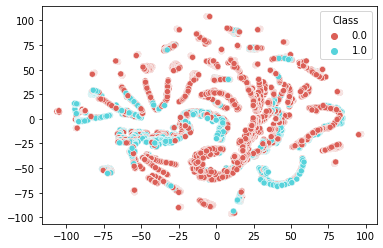

In [31]:
sns.scatterplot(x=tsne_obj[:,0],y=tsne_obj[:,1],hue=labels,palette=sns.hls_palette(2),legend='full')

In [55]:
canada_tsne = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                           'cluster':labels})

## Scatter plotting data based on clustering

<AxesSubplot:xlabel='X', ylabel='Y'>

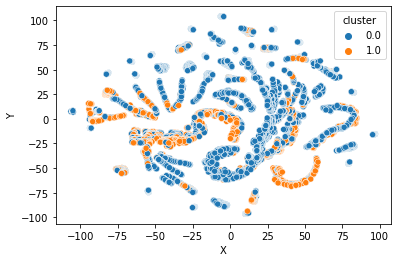

In [56]:
sns.scatterplot(x="X", y="Y",
              data=canada_tsne,
              hue='cluster',
              legend="full")

In [30]:
df1 = canada_tsne[canada_tsne['cluster']==1]

In [31]:
df2 = canada_tsne[canada_tsne['cluster']==0]

<AxesSubplot:xlabel='X', ylabel='Y'>

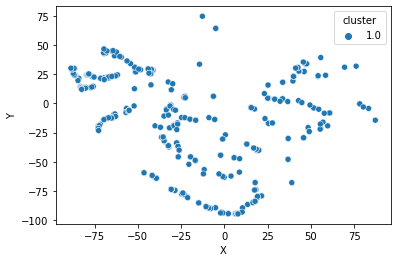

In [32]:
sns.scatterplot(x="X", y="Y",
              data=df1,
              hue='cluster',
              legend="full")

<AxesSubplot:xlabel='X', ylabel='Y'>

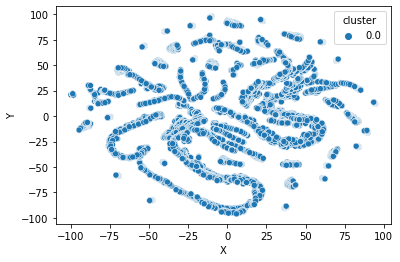

In [33]:
sns.scatterplot(x="X", y="Y",
              data=df2,
              hue='cluster',
              legend="full")

## Cluster = 0 Means Government don't need to put shutdown
## Cluster = 1 Means Government needs to put shutdown

## splitting data into train, validation and test  data set
### train = 60%
### validation = 20%
### test = 20%

In [27]:
X_train, X_test, y_train, y_test = train_test_split(canada, labels,
    test_size=0.2, shuffle = True, random_state = 8)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8)

In [28]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(5352, 7)
(5352,)
(1785, 7)
(1785,)
(1785, 7)
(1785,)


1. Create a shared word page on online where we all are accessible we all have access to it.
2. Power point presentation. another online powerpoint document /shared document. like previous onel.
3. we will use a model, to train our data.


In [35]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [36]:
# 1. Moving Average
df_ma = bothDF.numtoday.rolling(10, center=True, closed='both').mean()

In [67]:
# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(bothDF.numtoday, np.arange(len(bothDF.numtoday)), frac=0.05)[:, 1], index=bothDF.index, columns=['numtoday'])
df_loess_15 = pd.DataFrame(lowess(bothDF.numtoday, np.arange(len(bothDF.numtoday)), frac=0.15)[:, 1], index=bothDF.index, columns=['numtoday'])

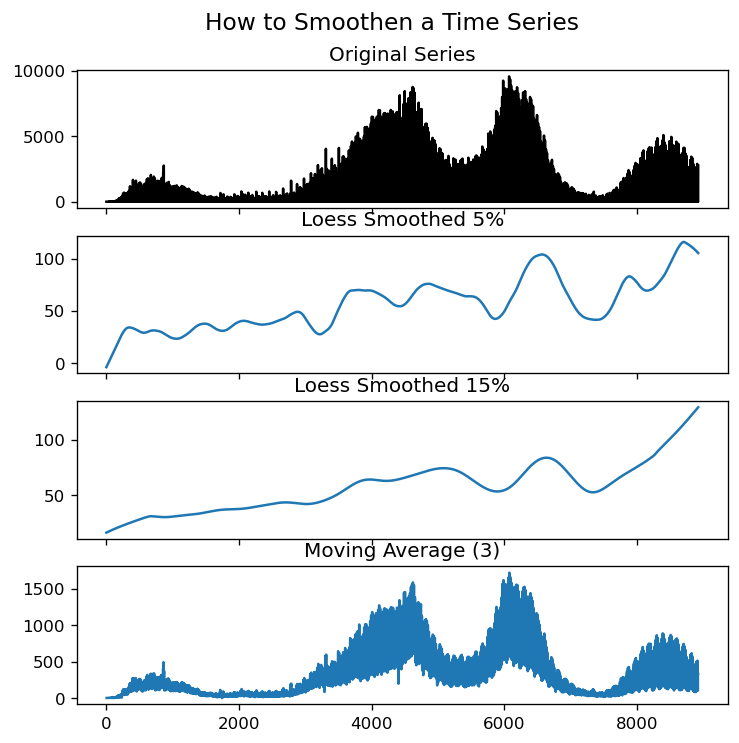

In [68]:
# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
bothDF['numtoday'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['numtoday'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['numtoday'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

In [82]:
bothDF.sort_values(by='date', inplace=True)
grpd = bothDF.groupby('pruid')
#using center=false to assign values on window's last row
bothDF['numtoday_mean'] = grpd['numtoday'].transform(lambda x: x.rolling(10, center=True, closed='both').mean())

In [83]:
bothDF.head(n=20)

pruid      date  numtoday  numdeathstoday  numteststoday  \
0      35  20200131         3             0.0            0.0   
1      59  20200131         1             0.0            0.0   
2       1  20200131         4             0.0            0.0   
3      35  20200208         0             0.0            0.0   
4      59  20200208         3             0.0            0.0   
..    ...       ...       ...             ...            ...   
17      1  20200225         1             0.0            0.0   
16     59  20200225         1             0.0            0.0   
15     35  20200225         0             0.0            0.0   
18     35  20200226         1             0.0            0.0   
19     59  20200226         0             0.0            0.0   

    numrecoveredtoday  numtoday_mean  
0                 0.0            NaN  
1                 0.0            NaN  
2                 0.0            NaN  
3                 0.0            NaN  
4                 0.0            NaN  
..                ...            ...  
17                0.0       2.400000  
16                0.0       0.800000  
15                0.0       1.500000  
18                0.0       1.818182  
19                0.0       1.090909  

[20 rows x 7 columns]

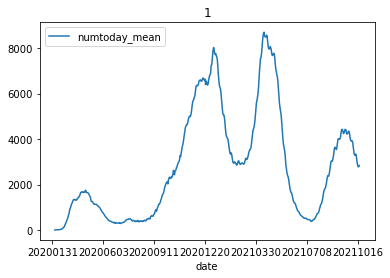

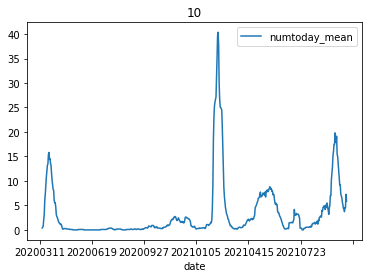

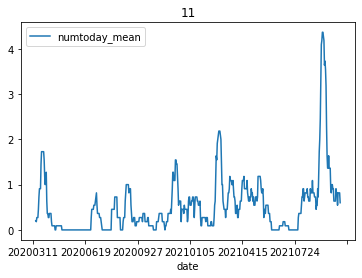

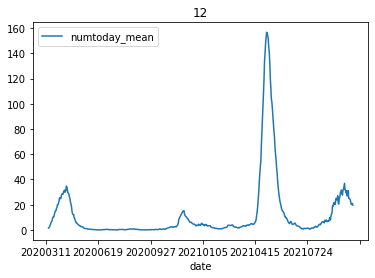

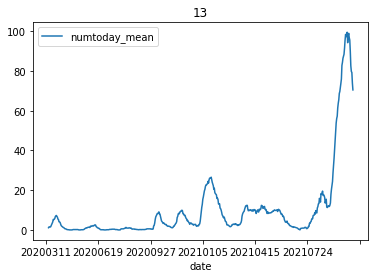

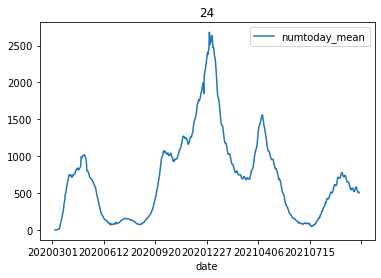

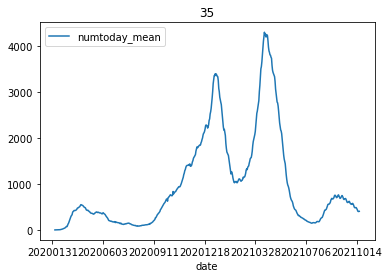

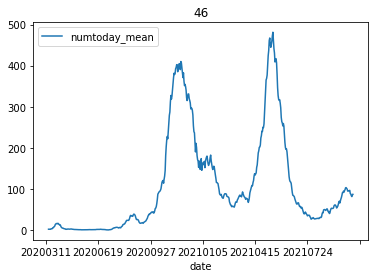

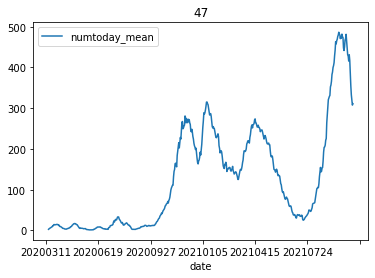

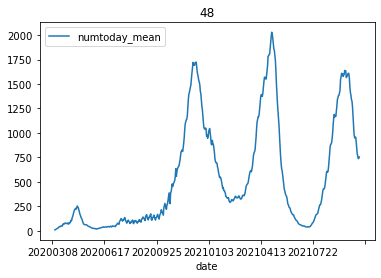

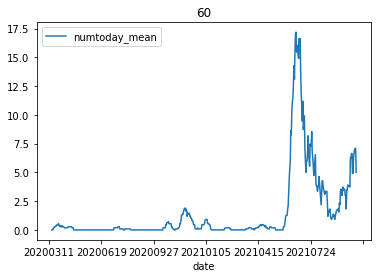

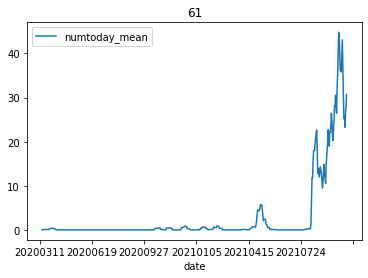

In [84]:
import matplotlib.pyplot as plt

for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='numtoday_mean', title=title)

In [109]:
#Grouping and applying rolling
bothDF['moving_numtoday'] = bothDF.groupby('pruid')['numtoday'].transform(lambda x: x.rolling(10, 1).mean())
bothDF['moving_numdeathstoday'] = bothDF.groupby('pruid')['numdeathstoday'].transform(lambda x: x.rolling(10, 1).mean())
bothDF['moving_numteststoday'] = bothDF.groupby('pruid')['numteststoday'].transform(lambda x: x.rolling(10, 1).mean())
bothDF['moving_numrecoveredtoday'] = bothDF.groupby('pruid')['numrecoveredtoday'].transform(lambda x: x.rolling(10, 1).mean())

In [110]:
bothDF.head()

pruid      date  numtoday  numdeathstoday  numteststoday  \
0     35  20200131         3             0.0            0.0   
1     59  20200131         1             0.0            0.0   
2      1  20200131         4             0.0            0.0   
3     35  20200208         0             0.0            0.0   
4     59  20200208         3             0.0            0.0   

   numrecoveredtoday  moving_numtoday  moving_numdeathstoday  \
0                0.0              3.0                    0.0   
1                0.0              1.0                    0.0   
2                0.0              4.0                    0.0   
3                0.0              1.5                    0.0   
4                0.0              2.0                    0.0   

   moving_numteststoday  moving_numrecoveredtoday  
0                   0.0                       0.0  
1                   0.0                       0.0  
2                   0.0                       0.0  
3                   0.0                       0.0  
4                   0.0                       0.0

In [85]:
for i, (name, group) in enumerate(bothDF.groupby('pruid')):
    group.to_csv('province-{}.csv'.format(i))

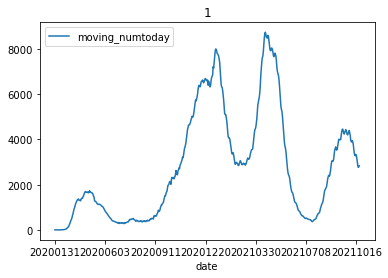

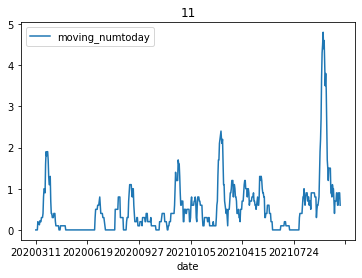

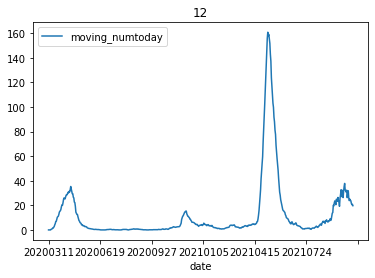

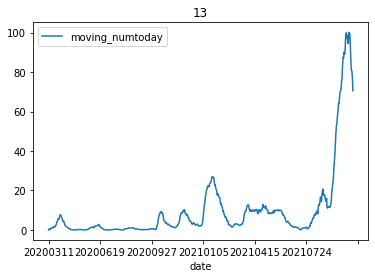

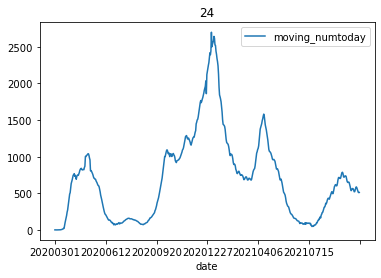

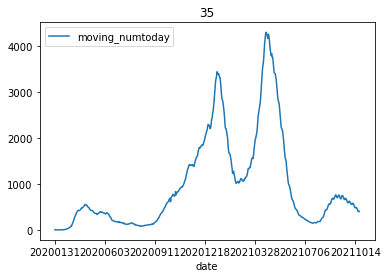

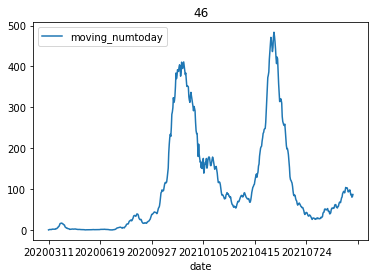

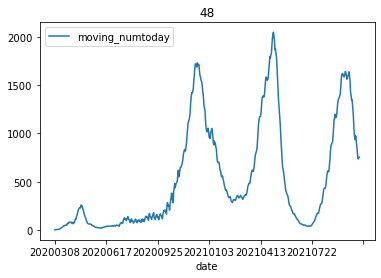

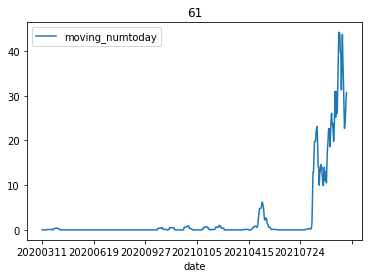

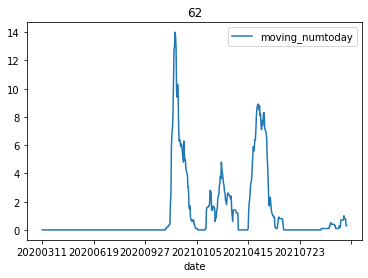

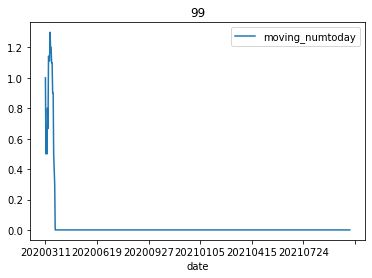

In [112]:
import matplotlib.pyplot as plt

for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numtoday', title=title)

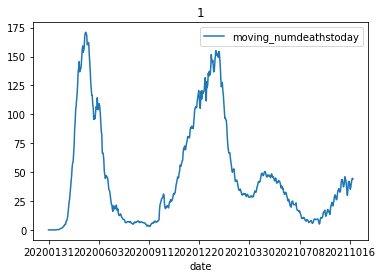

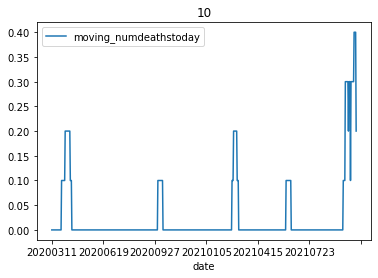

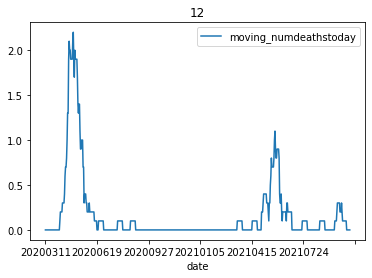

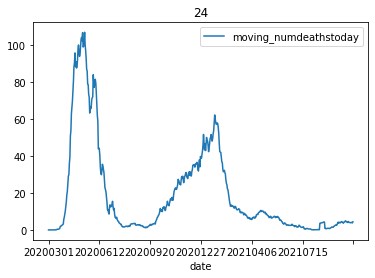

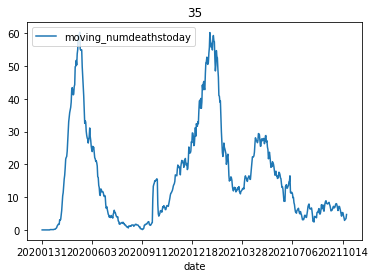

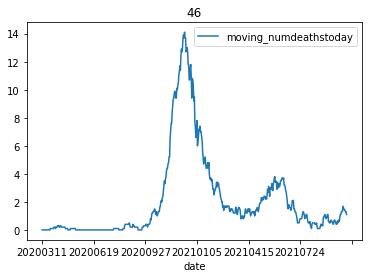

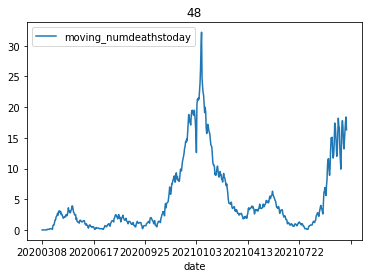

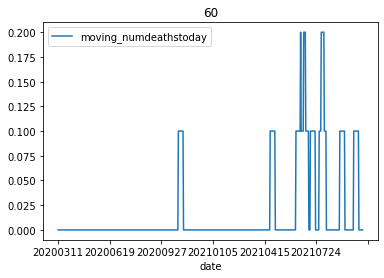

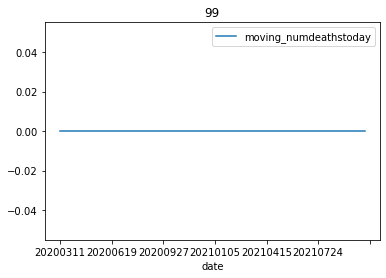

In [113]:
import matplotlib.pyplot as plt

for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numdeathstoday', title=title)

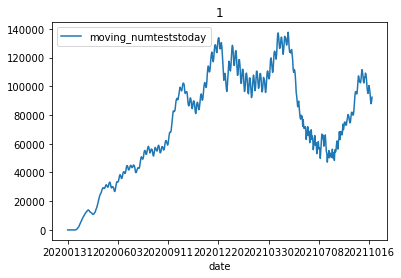

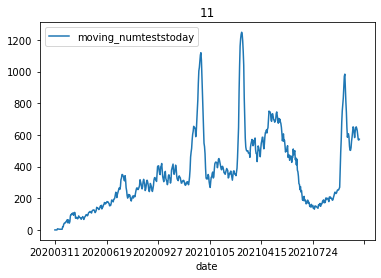

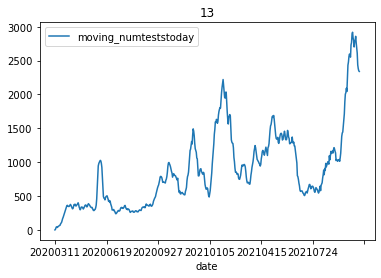

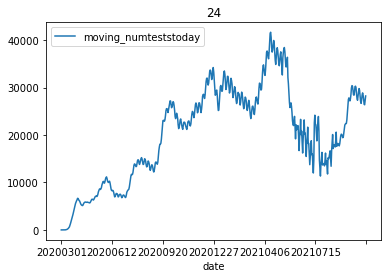

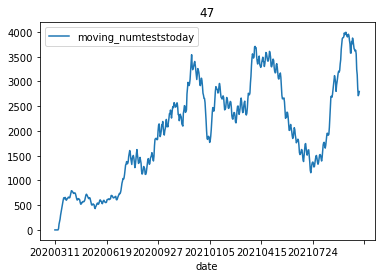

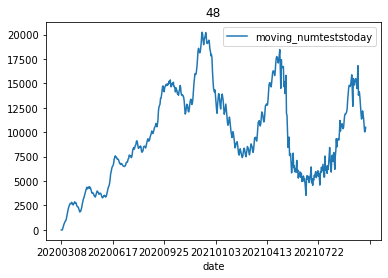

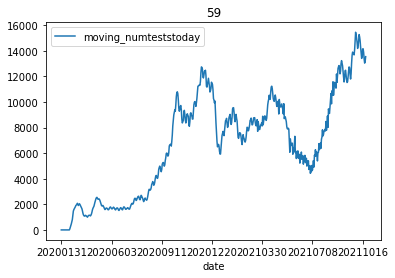

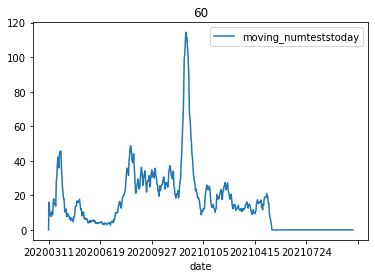

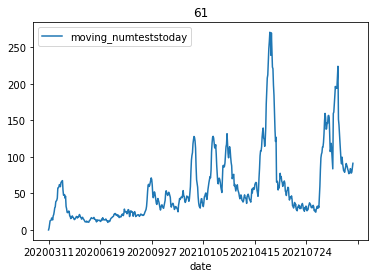

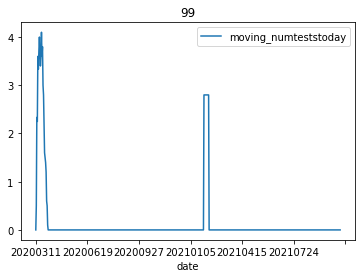

In [114]:
import matplotlib.pyplot as plt

for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numteststoday', title=title)

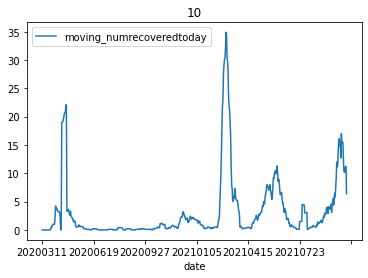

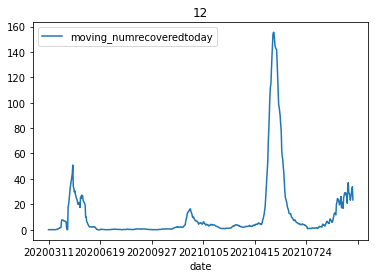

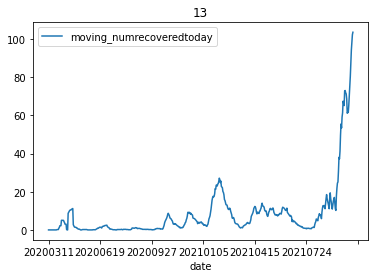

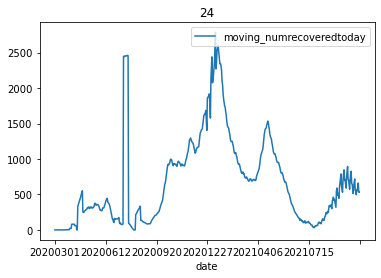

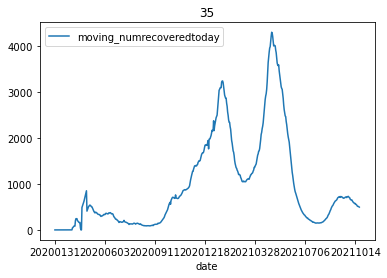

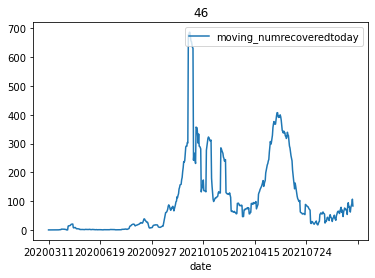

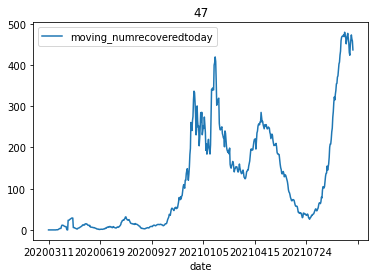

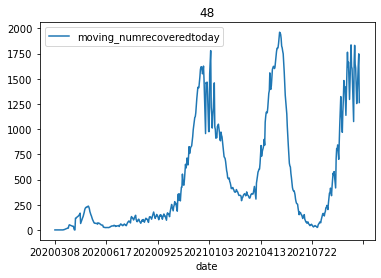

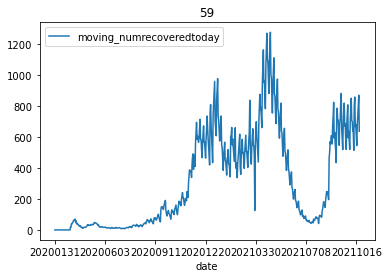

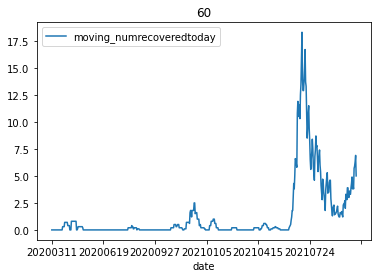

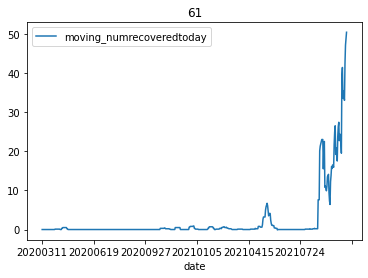

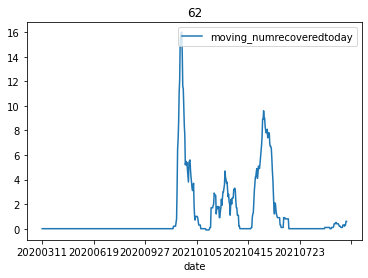

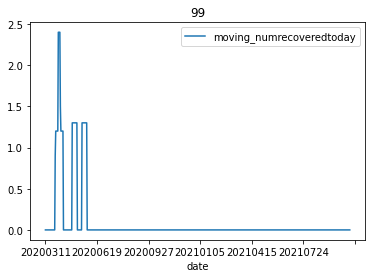

In [115]:
import matplotlib.pyplot as plt

for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numrecoveredtoday', title=title)

In [39]:
# 2. Loess Smoothing (5% and 15%)
bothDF['moving_numtoday_loess5%'] = pd.DataFrame(lowess(bothDF.numtoday, np.arange(len(bothDF.numtoday)), frac=0.05)[:, 1], index=bothDF.index, columns=['numtoday'])
bothDF['moving_numtoday_loess15%'] = pd.DataFrame(lowess(bothDF.numtoday, np.arange(len(bothDF.numtoday)), frac=0.15)[:, 1], index=bothDF.index, columns=['numtoday'])

bothDF['moving_numdeathstoday_loess5%'] = pd.DataFrame(lowess(bothDF.numdeathstoday, np.arange(len(bothDF.numdeathstoday)), frac=0.05)[:, 1], index=bothDF.index, columns=['numdeathstoday'])
bothDF['moving_numdeathstoday_loess15%'] = pd.DataFrame(lowess(bothDF.numdeathstoday, np.arange(len(bothDF.numdeathstoday)), frac=0.15)[:, 1], index=bothDF.index, columns=['numdeathstoday'])

bothDF['moving_numteststoday_loess5%'] = pd.DataFrame(lowess(bothDF.numteststoday, np.arange(len(bothDF.numteststoday)), frac=0.05)[:, 1], index=bothDF.index, columns=['numteststoday'])
bothDF['moving_numteststoday_loess15%'] = pd.DataFrame(lowess(bothDF.numteststoday, np.arange(len(bothDF.numteststoday)), frac=0.15)[:, 1], index=bothDF.index, columns=['numteststoday'])

bothDF['moving_numrecoveredtoday_loess5%'] = pd.DataFrame(lowess(bothDF.numrecoveredtoday, np.arange(len(bothDF.numrecoveredtoday)), frac=0.05)[:, 1], index=bothDF.index, columns=['numrecoveredtoday'])
bothDF['moving_numrecoveredtoday_loess15%'] = pd.DataFrame(lowess(bothDF.numrecoveredtoday, np.arange(len(bothDF.numrecoveredtoday)), frac=0.15)[:, 1], index=bothDF.index, columns=['numrecoveredtoday'])

In [149]:
bothDF.head()

pruid      date  numtoday  numdeathstoday  numteststoday  \
0     35  20200131         3             0.0            0.0   
1     59  20200131         1             0.0            0.0   
2      1  20200131         4             0.0            0.0   
3     35  20200208         0             0.0            0.0   
4     59  20200208         3             0.0            0.0   

   numrecoveredtoday  moving_numtoday  moving_numdeathstoday  \
0                0.0              3.0                    0.0   
1                0.0              1.0                    0.0   
2                0.0              4.0                    0.0   
3                0.0              1.5                    0.0   
4                0.0              2.0                    0.0   

   moving_numteststoday  moving_numrecoveredtoday  moving_numtoday_loess5%  \
0                   0.0                       0.0                -4.148117   
1                   0.0                       0.0                -4.012419   
2                   0.0                       0.0                -3.876679   
3                   0.0                       0.0                -3.740897   
4                   0.0                       0.0                -3.605072   

   moving_numtoday_loess15%  moving_numdeathstoday_loess5%  \
0                 15.760694                      -0.021523   
1                 15.789971                      -0.020313   
2                 15.819220                      -0.019104   
3                 15.848443                      -0.017894   
4                 15.877639                      -0.016685   

   moving_numdeathstoday_loess15%  moving_numteststoday_loess5%  \
0                        0.132072                    -45.785419   
1                        0.132340                    -41.563114   
2                        0.132608                    -37.343285   
3                        0.132876                    -33.125955   
4                        0.133144                    -28.911150   

   moving_numteststoday_loess15%  moving_numrecoveredtoday_loess5%  \
0                     421.550210                         -2.385014   
1                     422.766056                         -2.364928   
2                     423.981338                         -2.344780   
3                     425.196057                         -2.324572   
4                     426.410211                         -2.304302   

   moving_numrecoveredtoday_loess15%  
0                          -3.920607  
1                          -3.887188  
2                          -3.853765  
3                          -3.820337  
4                          -3.786905

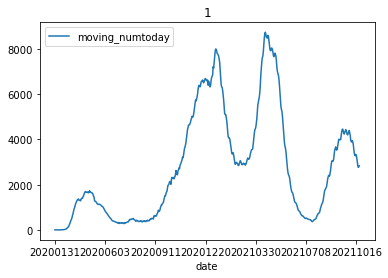

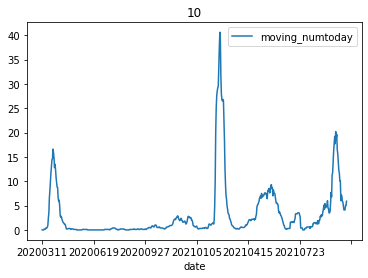

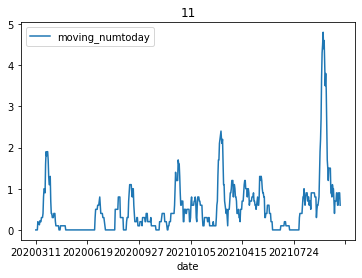

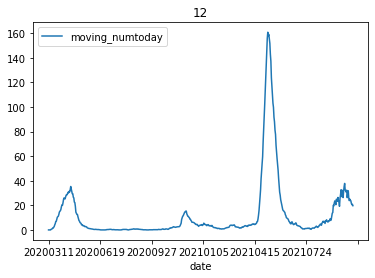

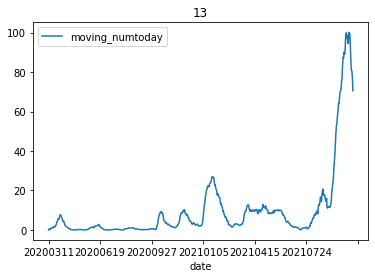

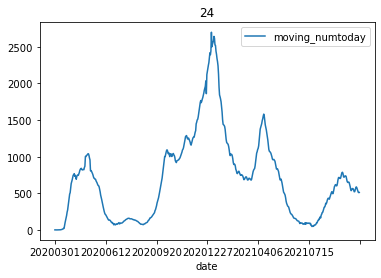

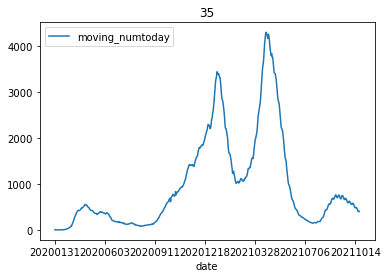

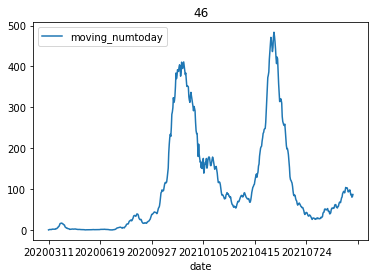

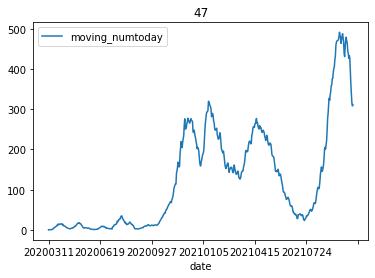

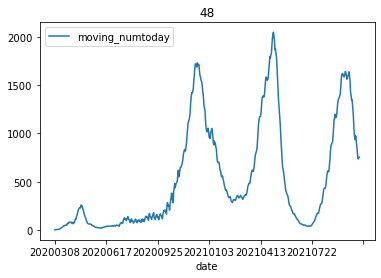

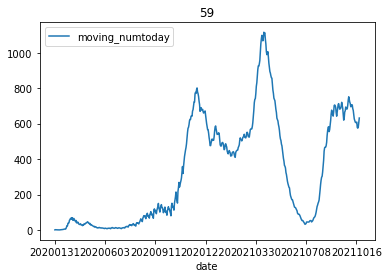

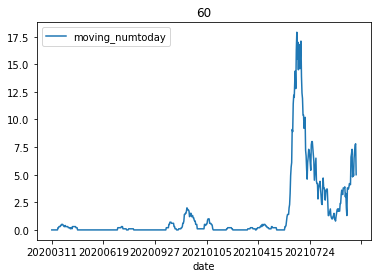

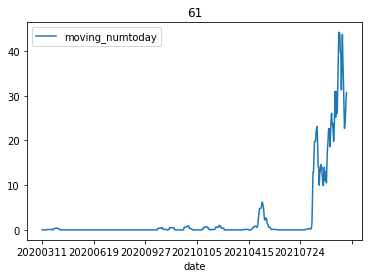

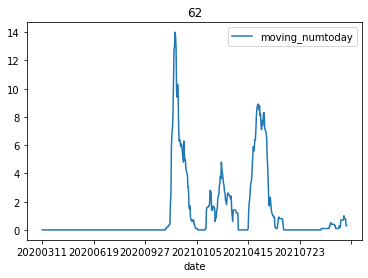

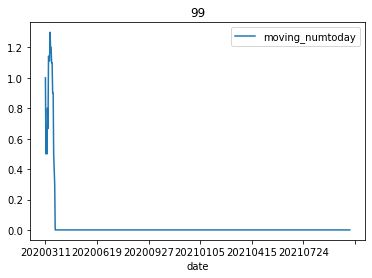

In [106]:
for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numtoday', title=title)

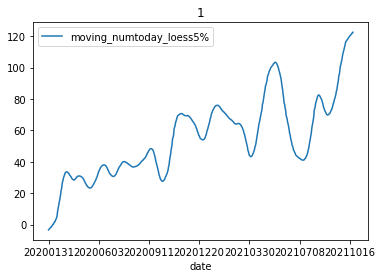

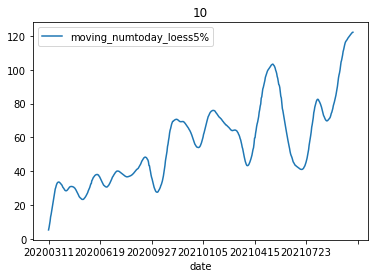

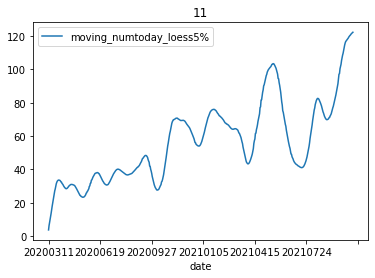

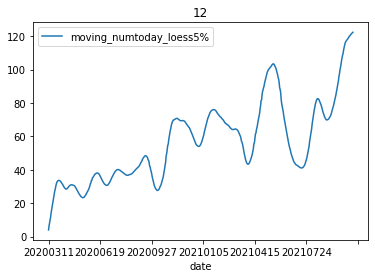

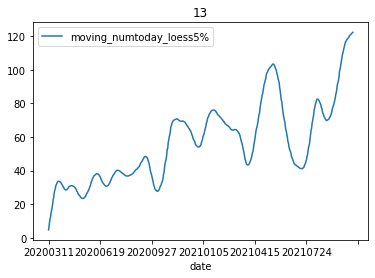

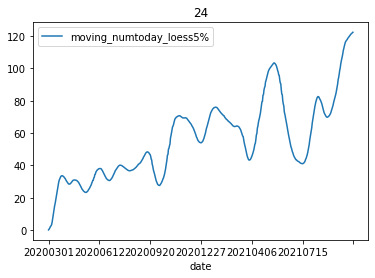

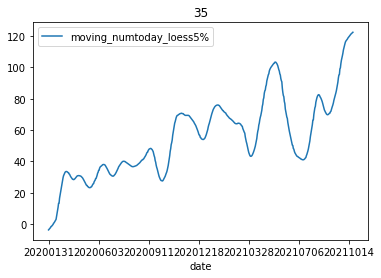

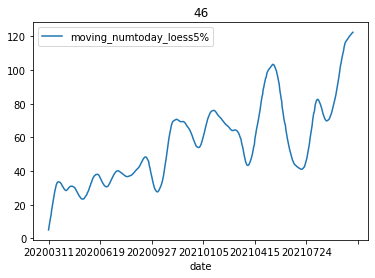

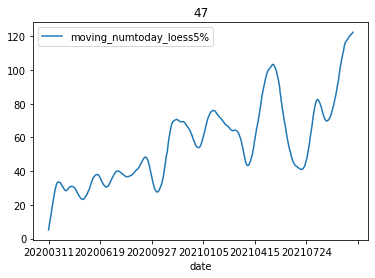

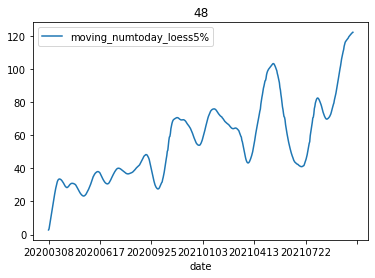

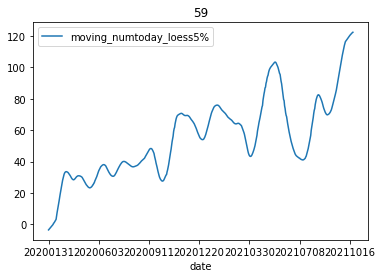

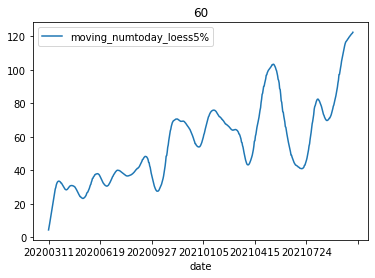

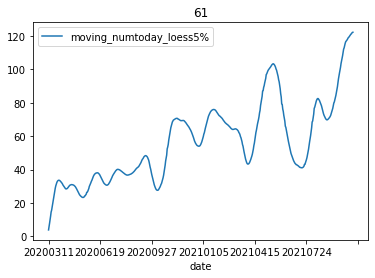

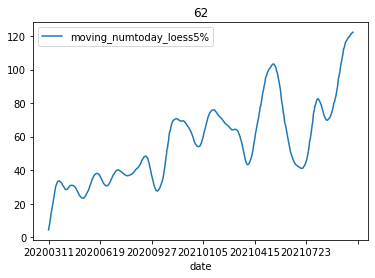

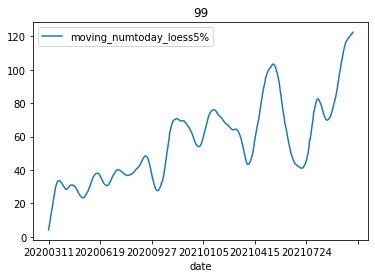

In [110]:
for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numtoday_loess5%', title=title)

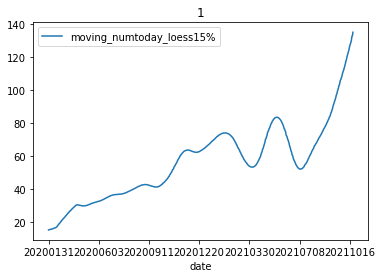

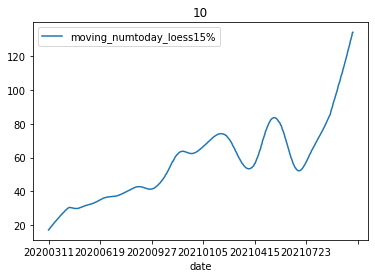

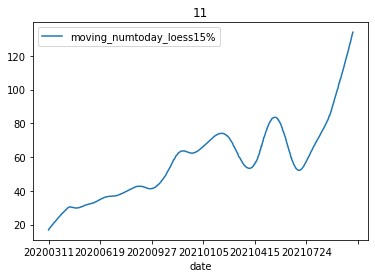

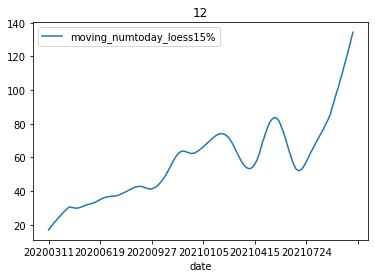

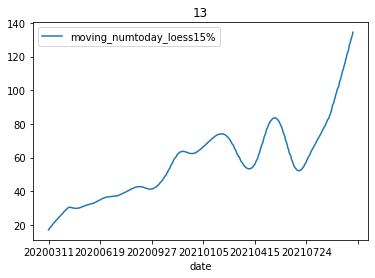

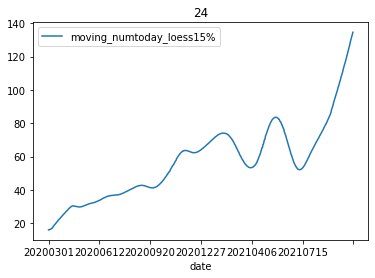

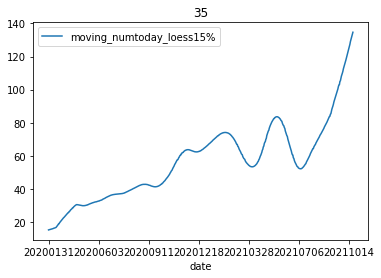

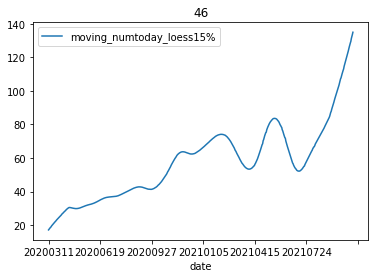

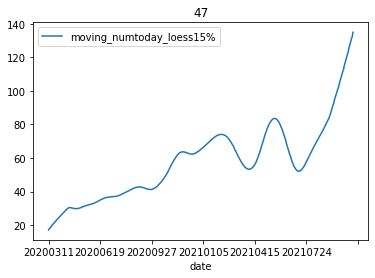

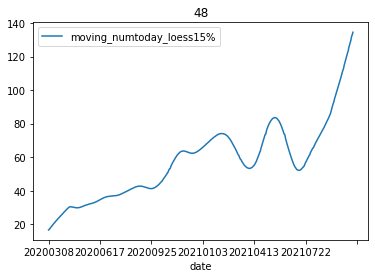

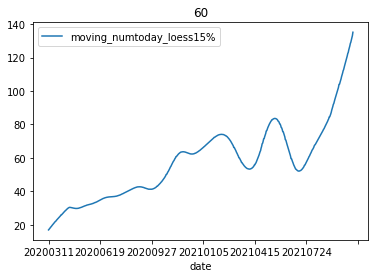

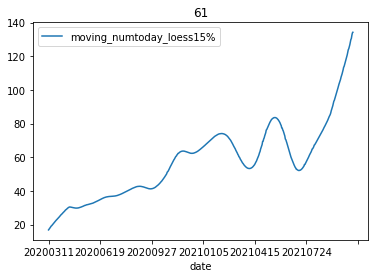

In [111]:
for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numtoday_loess15%', title=title)

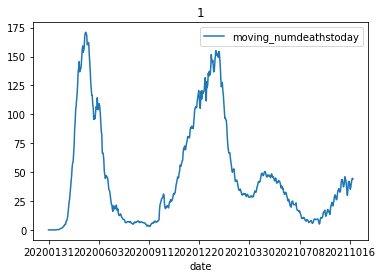

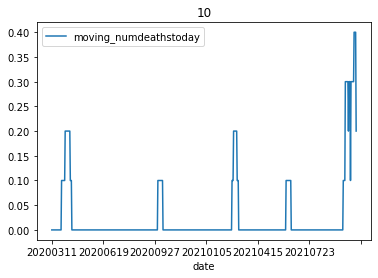

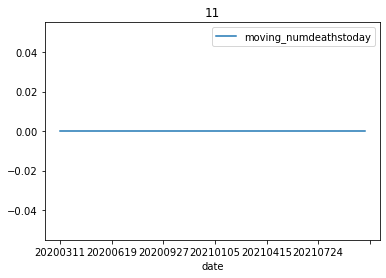

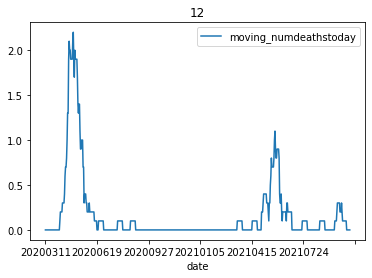

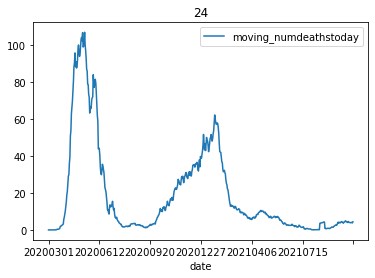

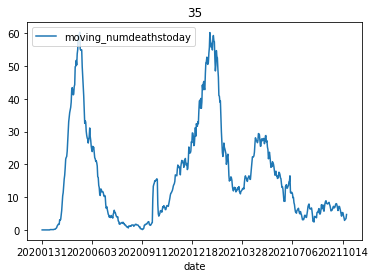

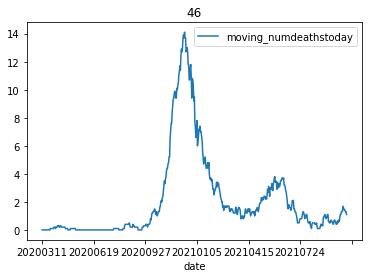

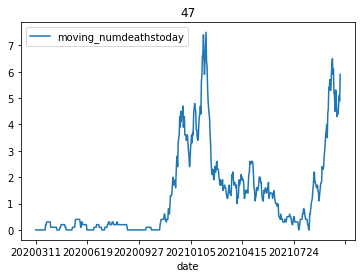

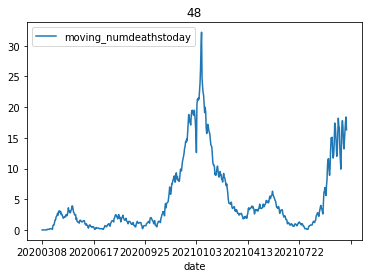

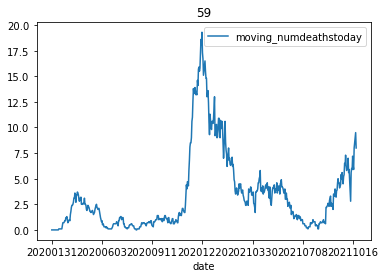

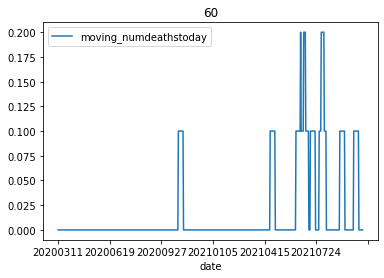

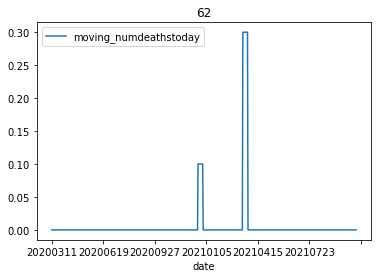

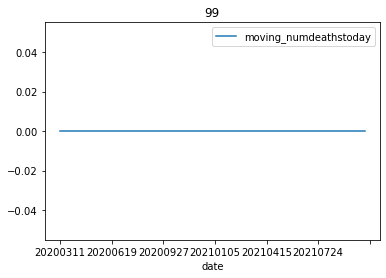

In [107]:
for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numdeathstoday', title=title)

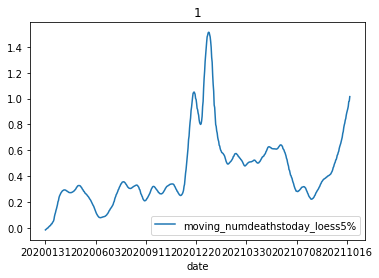

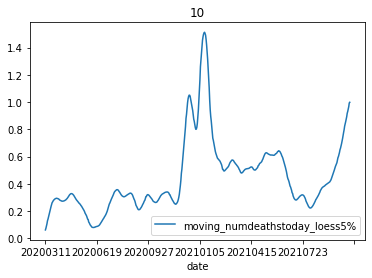

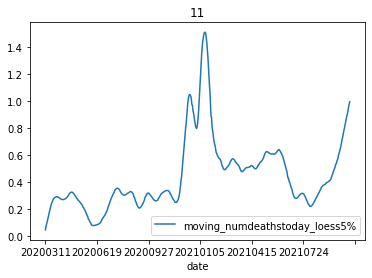

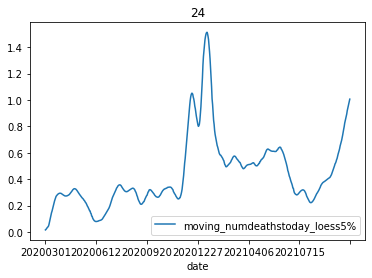

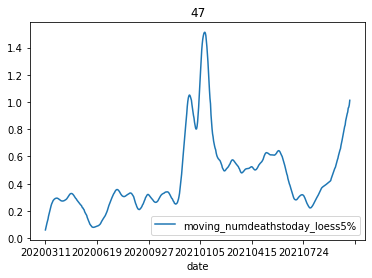

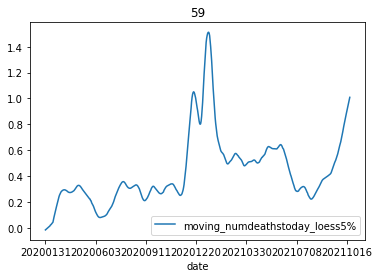

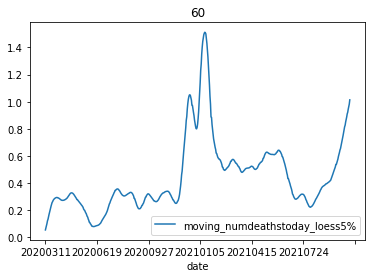

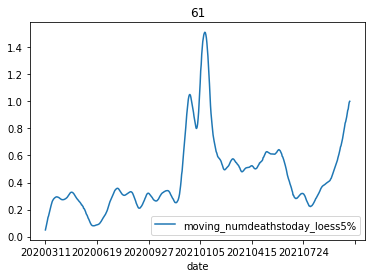

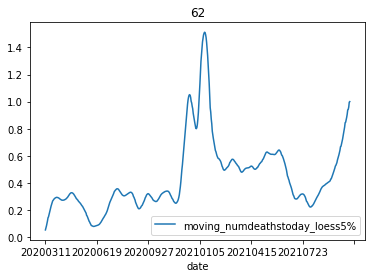

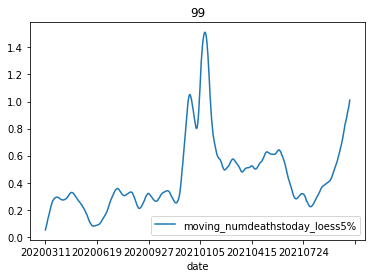

In [112]:
for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numdeathstoday_loess5%', title=title)

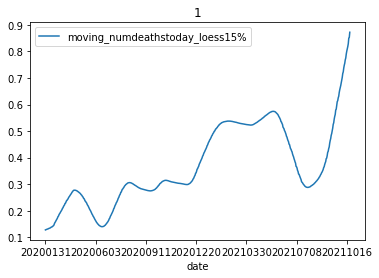

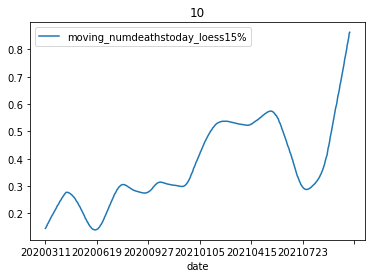

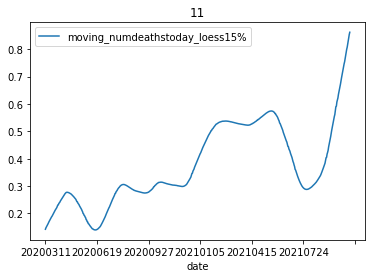

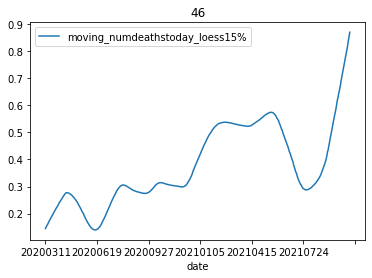

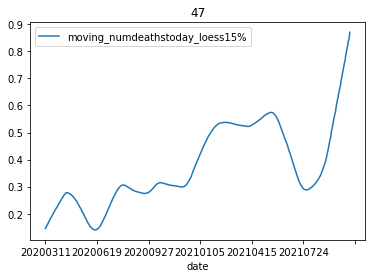

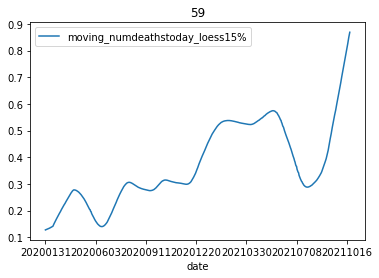

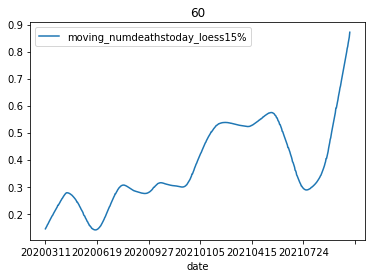

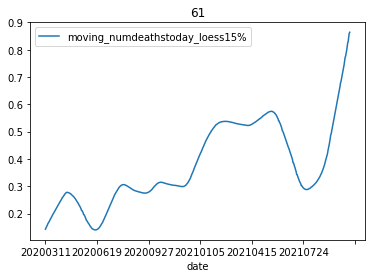

In [113]:
for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numdeathstoday_loess15%', title=title)

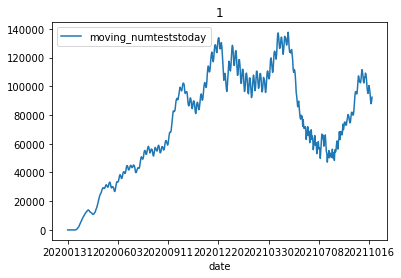

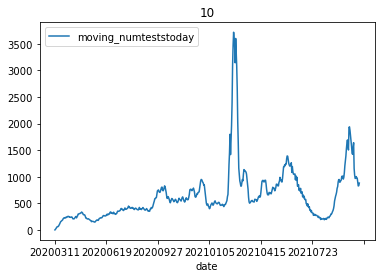

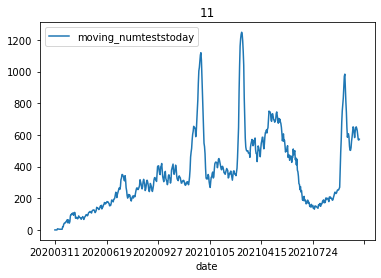

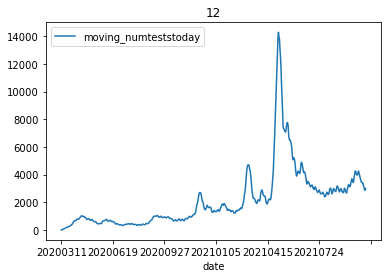

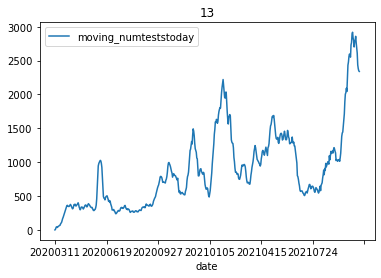

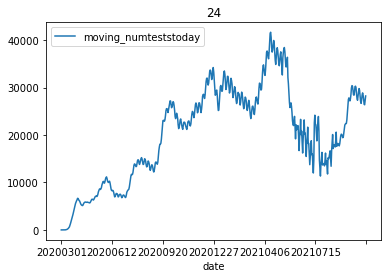

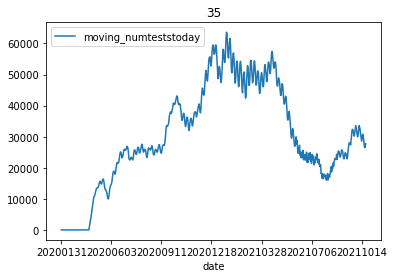

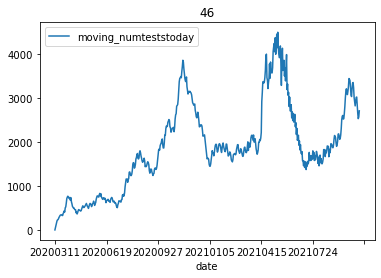

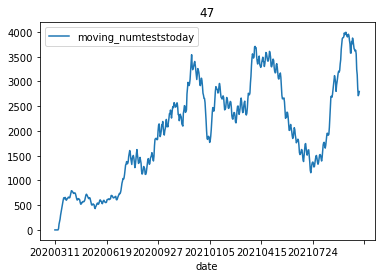

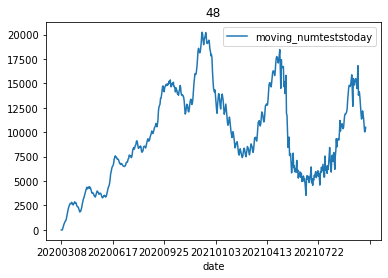

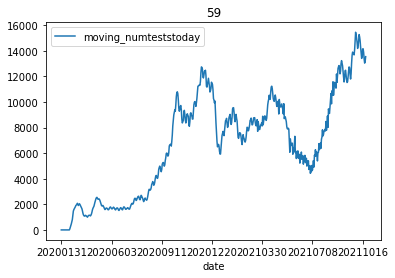

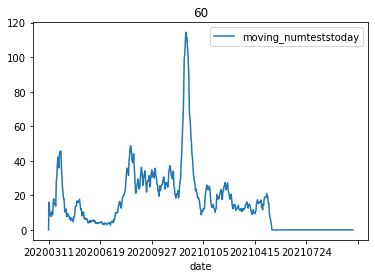

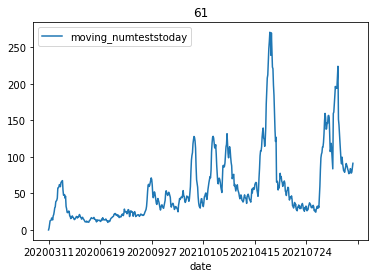

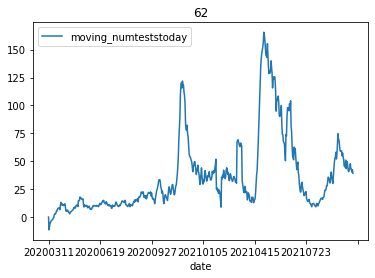

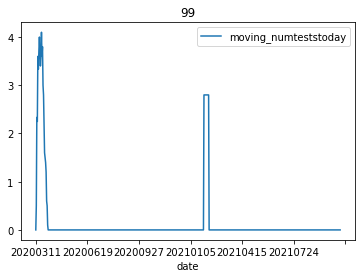

In [108]:
for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numteststoday', title=title)

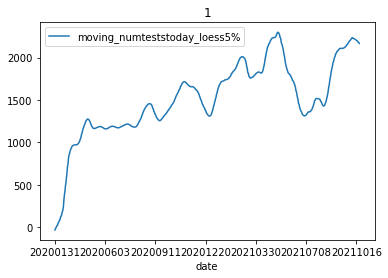

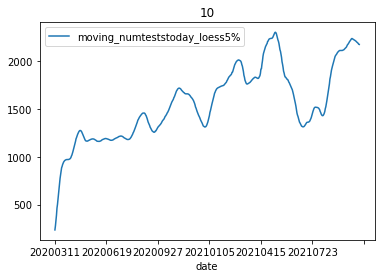

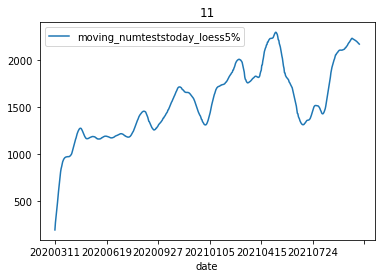

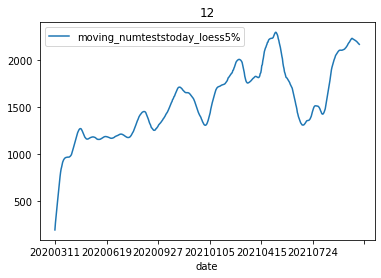

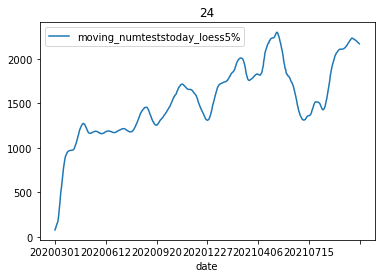

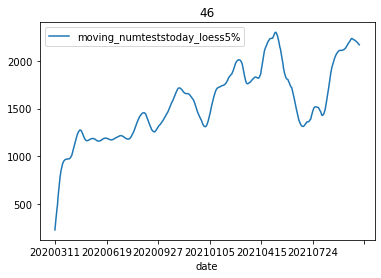

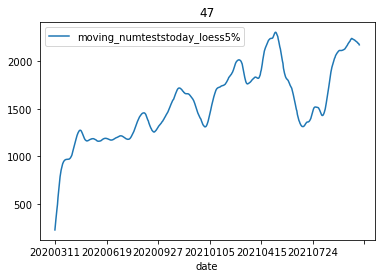

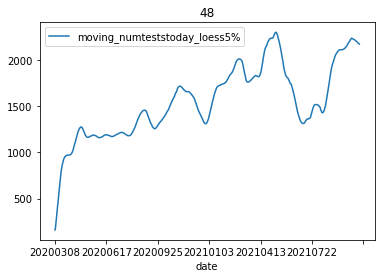

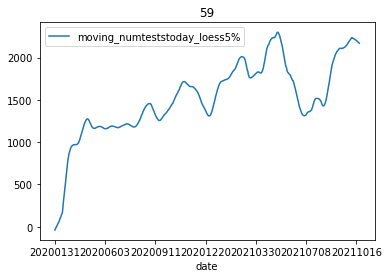

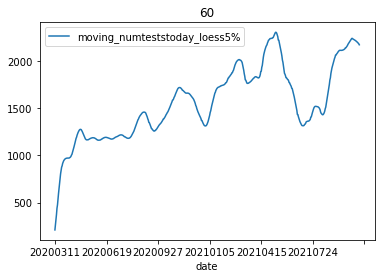

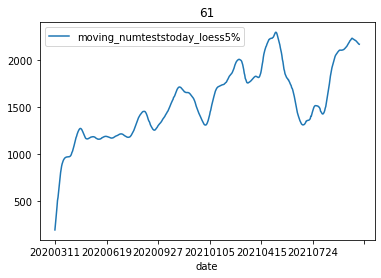

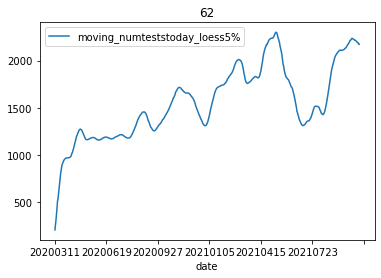

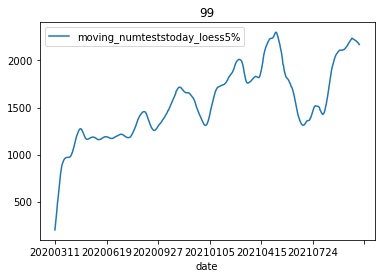

In [114]:
for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numteststoday_loess5%', title=title)

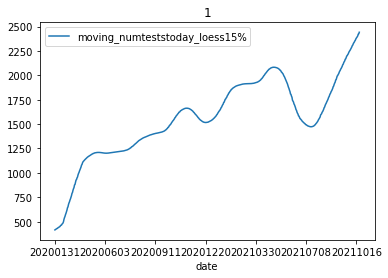

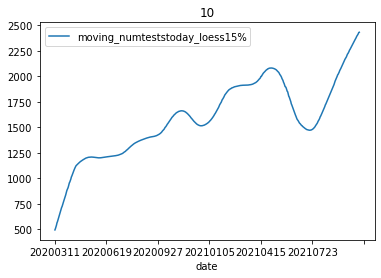

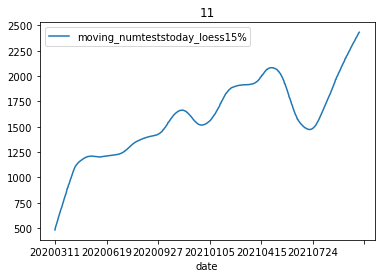

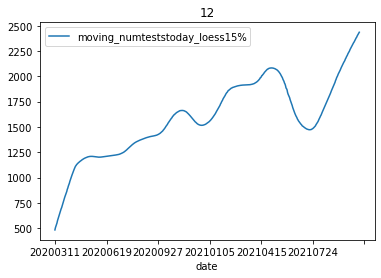

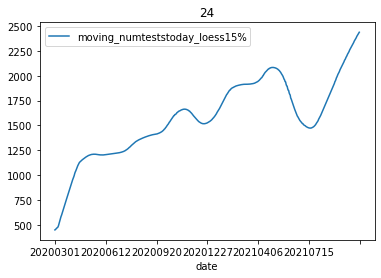

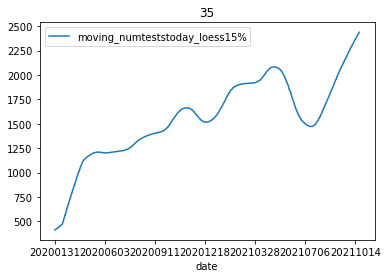

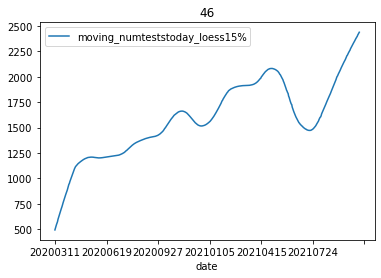

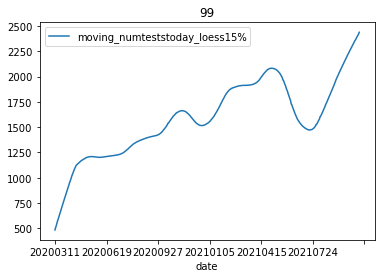

In [115]:
for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numteststoday_loess15%', title=title)

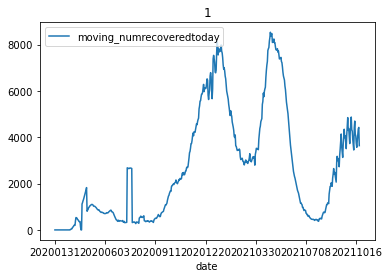

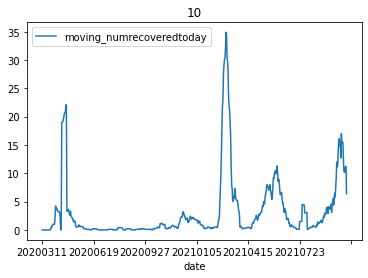

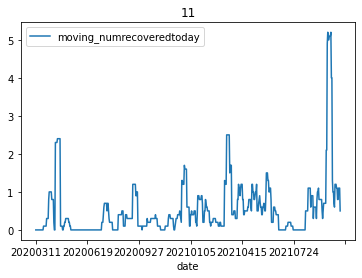

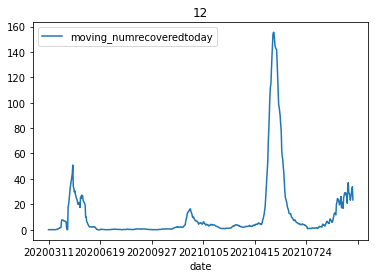

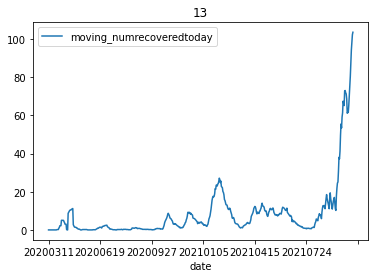

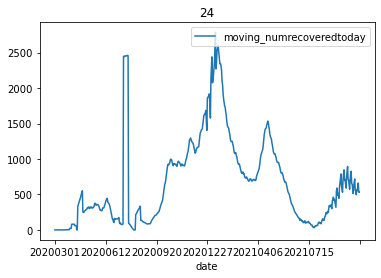

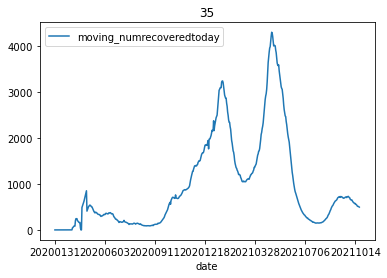

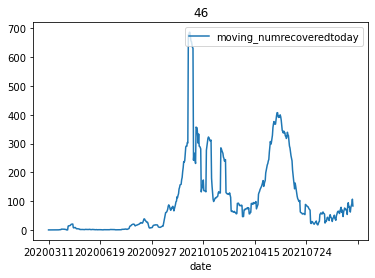

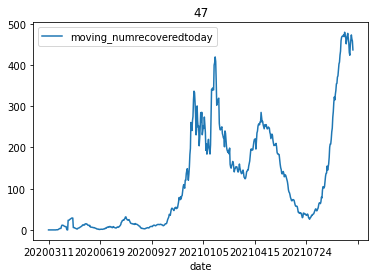

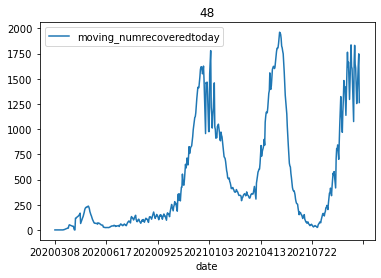

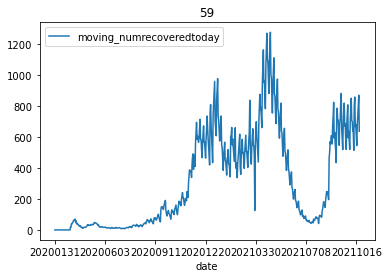

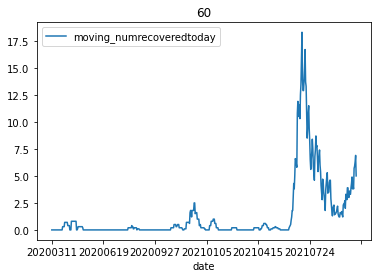

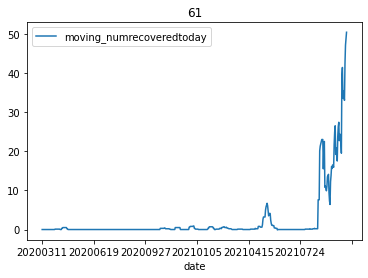

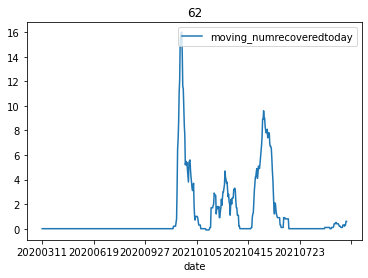

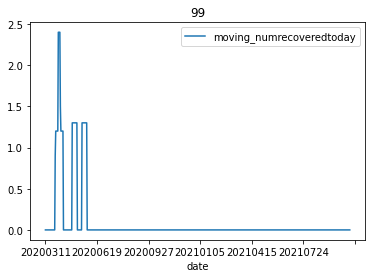

In [109]:
for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numrecoveredtoday', title=title)

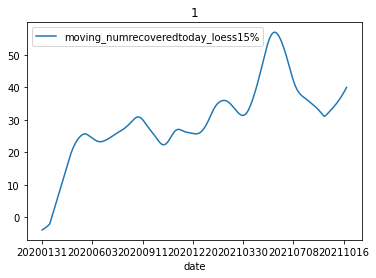

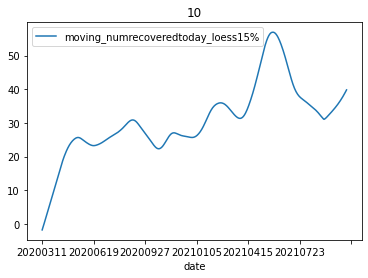

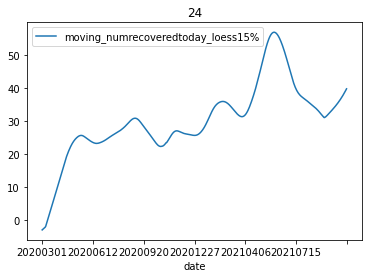

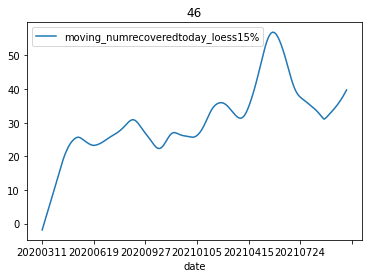

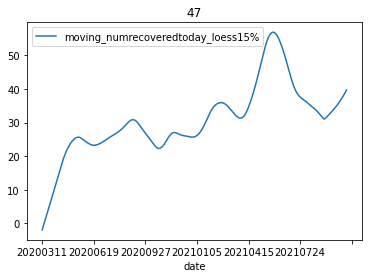

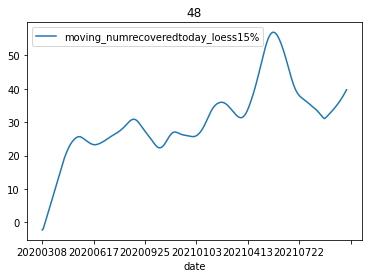

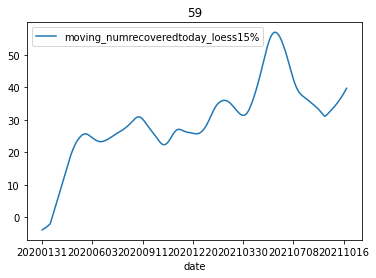

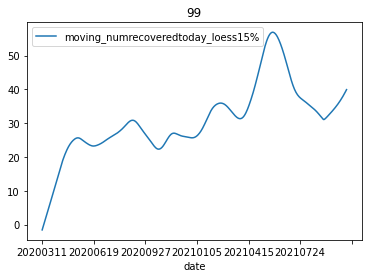

In [40]:
for title, group in bothDF.groupby('pruid'):
    group.plot(x='date', y='moving_numrecoveredtoday_loess15%', title=title)

In [83]:
moving_tsne= bothDF.copy()
moving_loess5= bothDF.copy()
moving_loess15= bothDF.copy()

In [151]:
moving_tsne.head()

pruid      date  numtoday  numdeathstoday  numteststoday  \
0     35  20200131         3             0.0            0.0   
1     59  20200131         1             0.0            0.0   
2      1  20200131         4             0.0            0.0   
3     35  20200208         0             0.0            0.0   
4     59  20200208         3             0.0            0.0   

   numrecoveredtoday  moving_numtoday  moving_numdeathstoday  \
0                0.0              3.0                    0.0   
1                0.0              1.0                    0.0   
2                0.0              4.0                    0.0   
3                0.0              1.5                    0.0   
4                0.0              2.0                    0.0   

   moving_numteststoday  moving_numrecoveredtoday  moving_numtoday_loess5%  \
0                   0.0                       0.0                -4.148117   
1                   0.0                       0.0                -4.012419   
2                   0.0                       0.0                -3.876679   
3                   0.0                       0.0                -3.740897   
4                   0.0                       0.0                -3.605072   

   moving_numtoday_loess15%  moving_numdeathstoday_loess5%  \
0                 15.760694                      -0.021523   
1                 15.789971                      -0.020313   
2                 15.819220                      -0.019104   
3                 15.848443                      -0.017894   
4                 15.877639                      -0.016685   

   moving_numdeathstoday_loess15%  moving_numteststoday_loess5%  \
0                        0.132072                    -45.785419   
1                        0.132340                    -41.563114   
2                        0.132608                    -37.343285   
3                        0.132876                    -33.125955   
4                        0.133144                    -28.911150   

   moving_numteststoday_loess15%  moving_numrecoveredtoday_loess5%  \
0                     421.550210                         -2.385014   
1                     422.766056                         -2.364928   
2                     423.981338                         -2.344780   
3                     425.196057                         -2.324572   
4                     426.410211                         -2.304302   

   moving_numrecoveredtoday_loess15%  
0                          -3.920607  
1                          -3.887188  
2                          -3.853765  
3                          -3.820337  
4                          -3.786905

In [152]:
moving_loess5.head()

pruid      date  numtoday  numdeathstoday  numteststoday  \
0     35  20200131         3             0.0            0.0   
1     59  20200131         1             0.0            0.0   
2      1  20200131         4             0.0            0.0   
3     35  20200208         0             0.0            0.0   
4     59  20200208         3             0.0            0.0   

   numrecoveredtoday  moving_numtoday  moving_numdeathstoday  \
0                0.0              3.0                    0.0   
1                0.0              1.0                    0.0   
2                0.0              4.0                    0.0   
3                0.0              1.5                    0.0   
4                0.0              2.0                    0.0   

   moving_numteststoday  moving_numrecoveredtoday  moving_numtoday_loess5%  \
0                   0.0                       0.0                -4.148117   
1                   0.0                       0.0                -4.012419   
2                   0.0                       0.0                -3.876679   
3                   0.0                       0.0                -3.740897   
4                   0.0                       0.0                -3.605072   

   moving_numtoday_loess15%  moving_numdeathstoday_loess5%  \
0                 15.760694                      -0.021523   
1                 15.789971                      -0.020313   
2                 15.819220                      -0.019104   
3                 15.848443                      -0.017894   
4                 15.877639                      -0.016685   

   moving_numdeathstoday_loess15%  moving_numteststoday_loess5%  \
0                        0.132072                    -45.785419   
1                        0.132340                    -41.563114   
2                        0.132608                    -37.343285   
3                        0.132876                    -33.125955   
4                        0.133144                    -28.911150   

   moving_numteststoday_loess15%  moving_numrecoveredtoday_loess5%  \
0                     421.550210                         -2.385014   
1                     422.766056                         -2.364928   
2                     423.981338                         -2.344780   
3                     425.196057                         -2.324572   
4                     426.410211                         -2.304302   

   moving_numrecoveredtoday_loess15%  
0                          -3.920607  
1                          -3.887188  
2                          -3.853765  
3                          -3.820337  
4                          -3.786905

In [153]:
moving_loess15.head()

pruid      date  numtoday  numdeathstoday  numteststoday  \
0     35  20200131         3             0.0            0.0   
1     59  20200131         1             0.0            0.0   
2      1  20200131         4             0.0            0.0   
3     35  20200208         0             0.0            0.0   
4     59  20200208         3             0.0            0.0   

   numrecoveredtoday  moving_numtoday  moving_numdeathstoday  \
0                0.0              3.0                    0.0   
1                0.0              1.0                    0.0   
2                0.0              4.0                    0.0   
3                0.0              1.5                    0.0   
4                0.0              2.0                    0.0   

   moving_numteststoday  moving_numrecoveredtoday  moving_numtoday_loess5%  \
0                   0.0                       0.0                -4.148117   
1                   0.0                       0.0                -4.012419   
2                   0.0                       0.0                -3.876679   
3                   0.0                       0.0                -3.740897   
4                   0.0                       0.0                -3.605072   

   moving_numtoday_loess15%  moving_numdeathstoday_loess5%  \
0                 15.760694                      -0.021523   
1                 15.789971                      -0.020313   
2                 15.819220                      -0.019104   
3                 15.848443                      -0.017894   
4                 15.877639                      -0.016685   

   moving_numdeathstoday_loess15%  moving_numteststoday_loess5%  \
0                        0.132072                    -45.785419   
1                        0.132340                    -41.563114   
2                        0.132608                    -37.343285   
3                        0.132876                    -33.125955   
4                        0.133144                    -28.911150   

   moving_numteststoday_loess15%  moving_numrecoveredtoday_loess5%  \
0                     421.550210                         -2.385014   
1                     422.766056                         -2.364928   
2                     423.981338                         -2.344780   
3                     425.196057                         -2.324572   
4                     426.410211                         -2.304302   

   moving_numrecoveredtoday_loess15%  
0                          -3.920607  
1                          -3.887188  
2                          -3.853765  
3                          -3.820337  
4                          -3.786905

In [84]:
moving_tsne.drop(['numtoday','numdeathstoday','numteststoday','numrecoveredtoday','moving_numtoday_loess5%','moving_numtoday_loess15%','moving_numdeathstoday_loess5%','moving_numdeathstoday_loess15%','moving_numteststoday_loess5%','moving_numteststoday_loess15%','moving_numrecoveredtoday_loess5%','moving_numrecoveredtoday_loess15%'], axis=1, inplace=True)

In [85]:
moving_loess5.drop(['numtoday','numdeathstoday','numteststoday','numrecoveredtoday','moving_numtoday','moving_numtoday_loess15%','moving_numdeathstoday','moving_numdeathstoday_loess15%','moving_numteststoday','moving_numteststoday_loess15%','moving_numrecoveredtoday','moving_numrecoveredtoday_loess15%'], axis=1, inplace=True)

In [86]:
moving_loess15.drop(['numtoday','numdeathstoday','numteststoday','numrecoveredtoday','moving_numtoday_loess5%','moving_numtoday','moving_numdeathstoday_loess5%','moving_numdeathstoday','moving_numteststoday_loess5%','moving_numteststoday','moving_numrecoveredtoday_loess5%','moving_numrecoveredtoday'], axis=1, inplace=True)

In [124]:
tsne = TSNE(n_components=2, random_state=0)
tsne_obj = tsne.fit_transform(moving_tsne)

In [125]:
canada_tsne = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                           'cluster':labels})

<AxesSubplot:xlabel='X', ylabel='Y'>

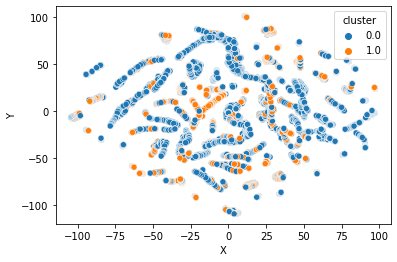

In [126]:
sns.scatterplot(x="X", y="Y",
              data=canada_tsne,
              hue='cluster',
              legend="full")

In [160]:
moving_loess5.head()

pruid      date  moving_numtoday_loess5%  moving_numdeathstoday_loess5%  \
0     35  20200131                -4.148117                      -0.021523   
1     59  20200131                -4.012419                      -0.020313   
2      1  20200131                -3.876679                      -0.019104   
3     35  20200208                -3.740897                      -0.017894   
4     59  20200208                -3.605072                      -0.016685   

   moving_numteststoday_loess5%  moving_numrecoveredtoday_loess5%  
0                    -45.785419                         -2.385014  
1                    -41.563114                         -2.364928  
2                    -37.343285                         -2.344780  
3                    -33.125955                         -2.324572  
4                    -28.911150                         -2.304302

In [157]:
#5% loess
tsne_loess5 = TSNE(n_components=2, random_state=0)
tsne_obj_loess5 = tsne.fit_transform(moving_loess5)

In [158]:
canada_tsne_loess5 = pd.DataFrame({'X':tsne_obj_loess5[:,0],
                        'Y':tsne_obj_loess5[:,1],
                           'cluster':labels})

<AxesSubplot:xlabel='X', ylabel='Y'>

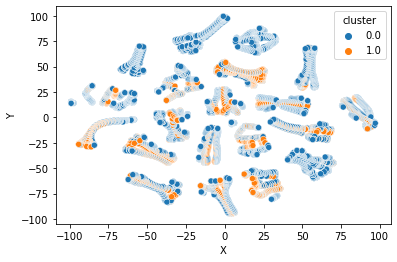

In [159]:
sns.scatterplot(x="X", y="Y",
              data=canada_tsne_loess5,
              hue='cluster',
              legend="full")

In [161]:
moving_loess15.head()

pruid      date  moving_numtoday_loess15%  moving_numdeathstoday_loess15%  \
0     35  20200131                 15.760694                        0.132072   
1     59  20200131                 15.789971                        0.132340   
2      1  20200131                 15.819220                        0.132608   
3     35  20200208                 15.848443                        0.132876   
4     59  20200208                 15.877639                        0.133144   

   moving_numteststoday_loess15%  moving_numrecoveredtoday_loess15%  
0                     421.550210                          -3.920607  
1                     422.766056                          -3.887188  
2                     423.981338                          -3.853765  
3                     425.196057                          -3.820337  
4                     426.410211                          -3.786905

In [162]:
#15% loess
tsne_loess15 = TSNE(n_components=2, random_state=0)
tsne_obj_loess15 = tsne.fit_transform(moving_loess15)

In [163]:
canada_tsne_loess15 = pd.DataFrame({'X':tsne_obj_loess15[:,0],
                        'Y':tsne_obj_loess15[:,1],
                           'cluster':labels})

<AxesSubplot:xlabel='X', ylabel='Y'>

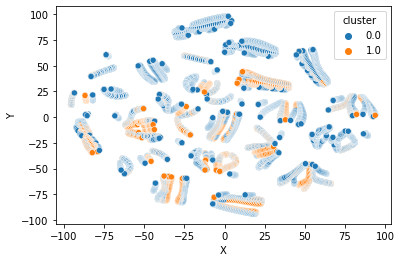

In [164]:
sns.scatterplot(x="X", y="Y",
              data=canada_tsne_loess15,
              hue='cluster',
              legend="full")

In [54]:
ontario = pd.read_csv('lockdwon-6.csv')

In [56]:
ontario.head()

Unnamed: 0  pruid        date  numtoday  numdeathstoday  numteststoday  \
0           0     35  2020-01-31         3             0.0            NaN   
1           3     35  2020-02-08         0             0.0            NaN   
2           6     35  2020-02-16         0             0.0            NaN   
3           9     35  2020-02-21         0             0.0            NaN   
4          12     35  2020-02-24         1             0.0            NaN   

   numrecoveredtoday  Class  
0                NaN    NaN  
1                NaN    NaN  
2                NaN    NaN  
3                NaN    NaN  
4                NaN    NaN

In [57]:
ontario.drop(['Unnamed: 0'], axis=1, inplace=True)

In [58]:
ontario.head()

pruid        date  numtoday  numdeathstoday  numteststoday  \
0     35  2020-01-31         3             0.0            NaN   
1     35  2020-02-08         0             0.0            NaN   
2     35  2020-02-16         0             0.0            NaN   
3     35  2020-02-21         0             0.0            NaN   
4     35  2020-02-24         1             0.0            NaN   

   numrecoveredtoday  Class  
0                NaN    NaN  
1                NaN    NaN  
2                NaN    NaN  
3                NaN    NaN  
4                NaN    NaN

In [59]:
ontario.fillna(value=0, inplace=True)

In [60]:
ontario.head()

pruid        date  numtoday  numdeathstoday  numteststoday  \
0     35  2020-01-31         3             0.0            0.0   
1     35  2020-02-08         0             0.0            0.0   
2     35  2020-02-16         0             0.0            0.0   
3     35  2020-02-21         0             0.0            0.0   
4     35  2020-02-24         1             0.0            0.0   

   numrecoveredtoday  Class  
0                0.0    0.0  
1                0.0    0.0  
2                0.0    0.0  
3                0.0    0.0  
4                0.0    0.0

In [62]:
olabels = ontario["Class"]

In [63]:
ontario.drop(['Class'], axis=1, inplace=True)

In [70]:
ontario["date"] = pd.to_datetime(ontario["date"]).dt.strftime("%Y%m%d")

In [71]:
ontario.head()

pruid      date  numtoday  numdeathstoday  numteststoday  numrecoveredtoday
0     35  20200131         3             0.0            0.0                0.0
1     35  20200208         0             0.0            0.0                0.0
2     35  20200216         0             0.0            0.0                0.0
3     35  20200221         0             0.0            0.0                0.0
4     35  20200224         1             0.0            0.0                0.0

In [72]:
ontario_tsne = TSNE(n_components=2, random_state=0)
ontariotsne_obj = ontario_tsne.fit_transform(ontario)

In [73]:
canada_ontario_tsne = pd.DataFrame({'X':ontariotsne_obj[:,0],
                        'Y':ontariotsne_obj[:,1],
                           'cluster':olabels})

<AxesSubplot:xlabel='X', ylabel='Y'>

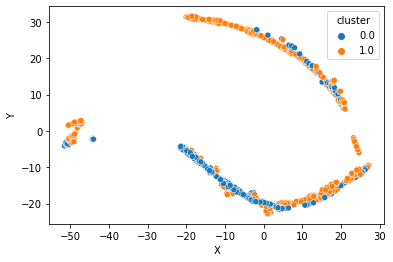

In [74]:
sns.scatterplot(x="X", y="Y",
              data=canada_ontario_tsne,
              hue='cluster',
              legend="full")

In [87]:
moving_tsne.head()

pruid      date  Class  moving_numtoday  moving_numdeathstoday  \
0     35  20200131    0.0              3.0                    0.0   
1     59  20200131    0.0              1.0                    0.0   
2      1  20200131    0.0              4.0                    0.0   
3     35  20200208    0.0              1.5                    0.0   
4     59  20200208    0.0              2.0                    0.0   

   moving_numteststoday  moving_numrecoveredtoday  
0                   0.0                       0.0  
1                   0.0                       0.0  
2                   0.0                       0.0  
3                   0.0                       0.0  
4                   0.0                       0.0

In [88]:
for i, (name, group) in enumerate(bothDF.groupby('pruid')):
    group.to_csv('lockdate-{}.csv'.format(i))

In [89]:
ontario_mov = pd.read_csv('lockdate-6.csv')

In [90]:
ontario_mov.head()

Unnamed: 0  pruid      date  numtoday  numdeathstoday  numteststoday  \
0           0     35  20200131         3             0.0            0.0   
1           3     35  20200208         0             0.0            0.0   
2           6     35  20200216         0             0.0            0.0   
3           9     35  20200221         0             0.0            0.0   
4          12     35  20200224         1             0.0            0.0   

   numrecoveredtoday  Class  moving_numtoday  moving_numdeathstoday  \
0                0.0    0.0             3.00                    0.0   
1                0.0    0.0             1.50                    0.0   
2                0.0    0.0             1.00                    0.0   
3                0.0    0.0             0.75                    0.0   
4                0.0    0.0             0.80                    0.0   

   moving_numteststoday  moving_numrecoveredtoday  moving_numtoday_loess5%  \
0                   0.0                       0.0                -4.148117   
1                   0.0                       0.0                -3.740897   
2                   0.0                       0.0                -3.333298   
3                   0.0                       0.0                -2.925325   
4                   0.0                       0.0                -2.516984   

   moving_numtoday_loess15%  moving_numdeathstoday_loess5%  \
0                 15.760694                      -0.021523   
1                 15.848443                      -0.017894   
2                 15.935948                      -0.014266   
3                 16.023206                      -0.010638   
4                 16.110217                      -0.007010   

   moving_numdeathstoday_loess15%  moving_numteststoday_loess5%  \
0                        0.132072                    -45.785419   
1                        0.132876                    -33.125955   
2                        0.133678                    -20.489214   
3                        0.134478                     -7.875879   
4                        0.135277                      4.713340   

   moving_numteststoday_loess15%  moving_numrecoveredtoday_loess5%  \
0                     421.550210                         -2.385014   
1                     425.196057                         -2.324572   
2                     428.836821                         -2.263575   
3                     432.472474                         -2.202010   
4                     436.102995                         -2.139865   

   moving_numrecoveredtoday_loess15%  
0                          -3.920607  
1                          -3.820337  
2                          -3.720028  
3                          -3.619680  
4                          -3.519294

In [91]:
ontario_mov.drop(['Unnamed: 0','numtoday','numdeathstoday','numteststoday','numrecoveredtoday','moving_numtoday_loess5%','moving_numtoday_loess15%','moving_numdeathstoday_loess5%','moving_numdeathstoday_loess15%','moving_numteststoday_loess5%','moving_numteststoday_loess15%','moving_numrecoveredtoday_loess5%','moving_numrecoveredtoday_loess15%'], axis=1, inplace=True)

In [92]:
ontario_mov.head()

pruid      date  Class  moving_numtoday  moving_numdeathstoday  \
0     35  20200131    0.0             3.00                    0.0   
1     35  20200208    0.0             1.50                    0.0   
2     35  20200216    0.0             1.00                    0.0   
3     35  20200221    0.0             0.75                    0.0   
4     35  20200224    0.0             0.80                    0.0   

   moving_numteststoday  moving_numrecoveredtoday  
0                   0.0                       0.0  
1                   0.0                       0.0  
2                   0.0                       0.0  
3                   0.0                       0.0  
4                   0.0                       0.0

In [94]:
onlabels = ontario_mov["Class"]

In [95]:
ontario_mov.drop(['Class'], axis=1, inplace=True)

In [96]:
ontario_mov["date"] = pd.to_datetime(ontario_mov["date"]).dt.strftime("%Y%m%d")

In [97]:
mov_tsne = TSNE(n_components=2, random_state=0)
mov_obj = ontario_tsne.fit_transform(ontario_mov)

In [99]:
mov_on_tsne = pd.DataFrame({'X':mov_obj[:,0],
                        'Y':mov_obj[:,1],
                           'cluster':onlabels})

<AxesSubplot:xlabel='X', ylabel='Y'>

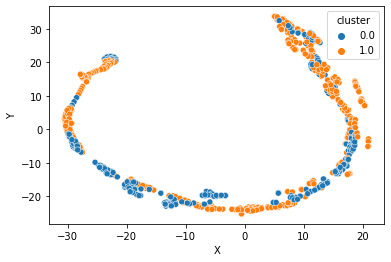

In [100]:
sns.scatterplot(x="X", y="Y",
              data=mov_on_tsne,
              hue='cluster',
              legend="full")